# Final Project

In [1]:
!pip install mglearn

In [2]:
!pip install scikit-plot

In [3]:
#load packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline, make_pipeline
import scikitplot as skplt
import warnings
warnings.filterwarnings("ignore")

Goal: create a model that predicts the artist that painted the painting

Testing: given the features of a new painting (not used in training) predict the artist: one of 9 classes (including "other" class)

Minimum requirements: 
1. 2 options for data normalization (none, min-max, standard)
2. PCA with 2 options for number of components
3. 4 different types of classifiers (KNN, MLP, SVC, RF)
4. Ensemble methods: Bagging and Adaboost
5. Use k-fold CV with k=4 for all validations (nested 4-fold if needed)
6. Use pipelines and gridsearch
7. Base algorithm/paramerter selection based on accuracy, AUC and F1



The folder contains three files:

1. extracted_features.csv: the x64 features extracted from the original raw images using a CNN.
The data contains a total of 2220 samples.

2. labels.csv contains the label mapping for each of the input samples. 
Labels are mapped as follows:

{0:'Pierre-Auguste_Renoir',
 1:'Raphael',
 2:'Leonardo_da_Vinci',
 3:'Sandro_Botticelli',
 4:'Francisco_Goya',
 5:'Vincent_van_Gogh',
 6:'Pablo_Picasso',
 7:'Albrecht_Durer',
 8:'Others'}

3. raw_images.csv contains the scaled pixel intensities of the raw input images. Each raw contains: 150x150x3 values. To visualize a given image img[i] run:
  plt.imshow(img[i].reshape(150,150,3))

In [4]:
#import data
features = pd.read_csv("extracted_features.csv", index_col=False, header=None)
labels = pd.read_csv("project_labels.csv",  index_col=False, header=None)
images=pd.read_csv("raw_images.csv", index_col=False, header=None)

In [5]:
features.shape, labels.shape, images.shape

((2220, 64), (2220, 1), (2220, 67500))

In [6]:
# some basic stats on the features
features.describe()

0            1            2            3            4   \
count  2220.0  2220.000000  2220.000000  2220.000000  2220.000000   
mean      0.0     6.601993     0.050044     3.540636     1.284573   
std       0.0    11.125774     0.603434     8.767412     4.070607   
min       0.0     0.000000     0.000000     0.000000     0.000000   
25%       0.0     0.000000     0.000000     0.000000     0.000000   
50%       0.0     0.000000     0.000000     0.000000     0.000000   
75%       0.0     9.344433     0.000000     0.000000     0.000000   
max       0.0   107.223625    12.181565    77.097630    48.539112   

                5            6            7            8            9   ...  \
count  2220.000000  2220.000000  2220.000000  2220.000000  2220.000000  ...   
mean      0.953533     0.633569     3.391605     0.516075     1.359155  ...   
std       3.159986     3.183287     6.537269     2.136873     3.916918  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
50%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
75%       0.000000     0.000000     4.161618     0.000000     0.000000  ...   
max      48.284073    38.147220    57.333443    27.934464    36.574150  ...   

                54           55           56          57           58      59  \
count  2220.000000  2220.000000  2220.000000  2220.00000  2220.000000  2220.0   
mean      7.756746     3.869980     4.652292     1.81051     1.404614     0.0   
std      10.130543     8.344778     9.792057     4.77292     3.673802     0.0   
min       0.000000     0.000000     0.000000     0.00000     0.000000     0.0   
25%       0.000000     0.000000     0.000000     0.00000     0.000000     0.0   
50%       3.483127     0.000000     0.000000     0.00000     0.000000     0.0   
75%      12.701961     3.851429     4.190937     0.00000     0.158277     0.0   
max      80.734630   102.397160    71.262665    38.66499    30.037903     0.0   

                60           61      62           63  
count  2220.000000  2220.000000  2220.0  2220.000000  
mean      3.593796     3.926972     0.0     0.939838  
std       7.799738     7.307944     0.0     3.490395  
min       0.000000     0.000000     0.0     0.000000  
25%       0.000000     0.000000     0.0     0.000000  
50%       0.000000     0.000000     0.0     0.000000  
75%       3.745182     4.971634     0.0     0.000000  
max      80.509530    65.354930     0.0    36.717970  

[8 rows x 64 columns]

Text(0.5, 1.0, 'class distribution')

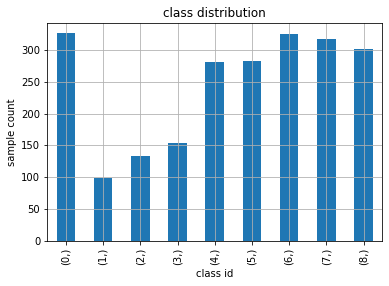

In [7]:
# check the classes distribution
labels.value_counts(sort=False).plot(kind='bar')
plt.grid()
plt.xlabel('class id')
plt.ylabel('sample count')
plt.title('class distribution')

In [8]:
#split data into testing and training
indices = np.arange(len(features))

X_train, X_test, y_train, y_test, idx1, idx2 = train_test_split(features.values, labels.values, indices, random_state=0, test_size=0.1 )

img_train = images.values[idx1,:] # training images
img_test = images.values[idx2,:] # testing images

y_train = y_train.ravel()
y_test = y_test.ravel()

In [9]:
X_train.shape, y_train.shape, img_train.shape

((1998, 64), (1998,), (1998, 67500))

In [10]:
X_test.shape, y_test.shape, img_test.shape

((222, 64), (222,), (222, 67500))

In [11]:
# create a function for showing the images
def showImage(data):
    some_article = data
    some_article_image = some_article.reshape(150,150,3) # Reshaping it to get the 150x150 pixels
    plt.imshow(some_article_image, cmap = matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()

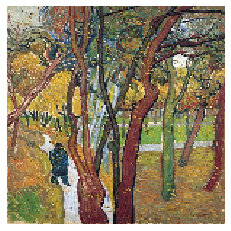

In [12]:
showImage(img_train[1])

In [13]:
labels=['Pierre-Auguste Renoir', 
        'Raphael', 
        'Leonardo da Vinci', 
        'Sandro Botticelli', 
        'Francisco Goya', 
        'Vincent van Gogh', 
        'Pablo Picasso', 
        'Albrecht Durer', 
        'Others']

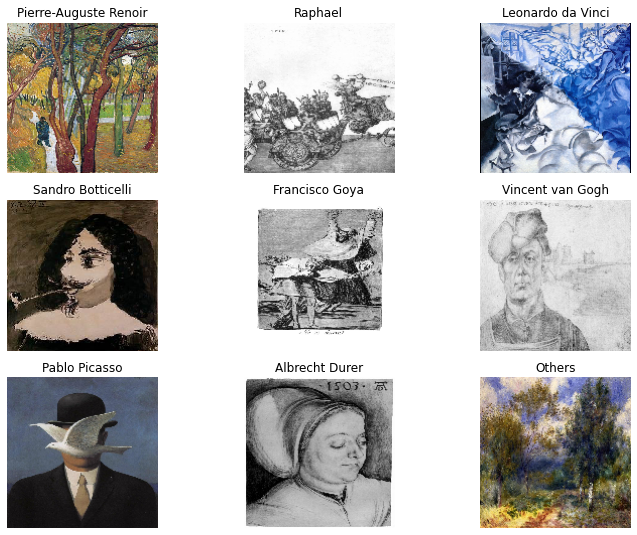

In [14]:
# plot a sample from each class
plt.figure(figsize=(10,10))
for c in np.unique(y_train):
  plt.subplot(4,3,c+1)
  idx = np.where(y_test == c)
  plt.imshow(img_train[idx[0][0]].reshape(150,150,3))
  plt.axis('off')
  plt.title(str(labels[c]))
  plt.tight_layout()

# Data Normalization

### KNN

In [15]:
# pipe for KNN
from sklearn.pipeline import Pipeline
knn_pipe = Pipeline([('scaler', StandardScaler()),('classifier',KNeighborsClassifier())])
#knn_pipe.get_params()

In [16]:
# different scaling methods to try
scalers_to_test = [None, StandardScaler(), MinMaxScaler()]
# grid search with scalers and k
params = {'scaler': scalers_to_test}

In [17]:
# Find best parameters using grid search with accuracy
knn_gs = GridSearchCV(knn_pipe, 
                      params,
                      cv=4, 
                      scoring='accuracy')
#Fit model
knn_gs.fit(X_train,y_train)

print('Train Accuracy : %.3f'%knn_gs.score(X_train, y_train))
print('Test Accuracy : %.3f'%knn_gs.score(X_test, y_test))
print('Best Parameters : ',knn_gs.best_params_)
#print('All results : ',pd.DataFrame(knn_gs.cv_results_))

Train Accuracy : 0.911
Test Accuracy : 0.838
Best Parameters :  {'scaler': None}


In [18]:
#create the F1 scorer
f1 = make_scorer(f1_score , average='macro')

In [19]:
# Find best parameters using grid search with f1 score

knn_gs = GridSearchCV(knn_pipe, 
                      params,
                      cv=4, 
                      scoring=f1)
#Fit model
knn_gs.fit(X_train,y_train)

print('Train F1 score : %.3f'%knn_gs.score(X_train, y_train))
print('Test F1 score : %.3f'%knn_gs.score(X_test, y_test))
print('Best Parameters : ',knn_gs.best_params_)
#print('All results : ',pd.DataFrame(knn_gs.cv_results_))

Train F1 score : 0.905
Test F1 score : 0.826
Best Parameters :  {'scaler': None}


In [20]:
# Find best parameters using grid search with ROC
knn_gs = GridSearchCV(knn_pipe, 
                      params,
                      cv=4,  
                      scoring='roc_auc_ovr')
#Fit model
knn_gs.fit(X_train,y_train)

print('Train ROC : %.3f'%knn_gs.score(X_train, y_train))
print('Test ROC : %.3f'%knn_gs.score(X_test, y_test))
print('Best Parameters : ',knn_gs.best_params_)
#print('All results : ',pd.DataFrame(knn_gs.cv_results_))

Train ROC : 0.996
Test ROC : 0.970
Best Parameters :  {'scaler': None}


### SVC

In [21]:
# pipe for SVC
from sklearn.pipeline import Pipeline
svc_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier',SVC(random_state=0,probability=True))])
#svc_pipe.get_params()

In [22]:
# different scaling methods to try
scalers_to_test = [None, StandardScaler(), MinMaxScaler()]
# grid search with scalers and different kernels
params = {'scaler': scalers_to_test,
        'classifier__kernel': ['linear','poly','rbf'],}

In [23]:
# Find best parameters using grid search with accuracy
svc_gs = GridSearchCV(svc_pipe, 
                      params,
                      cv=4,
                      scoring='accuracy')
#Fit model
svc_gs.fit(X_train,y_train)

print('Training accuracy score : %.3f'%svc_gs.score(X_train, y_train))
print('Testing accuracy score : %.3f'%svc_gs.score(X_test, y_test))
print('Best Parameters : ',svc_gs.best_params_)
#print('All results : ',pd.DataFrame(svc_gs.cv_results_))

Training accuracy score : 0.974
Testing accuracy score : 0.923
Best Parameters :  {'classifier__kernel': 'rbf', 'scaler': MinMaxScaler()}


In [24]:
# Find best parameters using grid search with f1 score

svc_gs = GridSearchCV(svc_pipe, 
                      params,
                      cv=4,  
                      scoring=f1)

#Fit model
svc_gs.fit(X_train,y_train)
print('Training f1 score : %.3f'%svc_gs.score(X_train, y_train))
print('Testing f1 score : %.3f'%svc_gs.score(X_test, y_test))
print('Best Parameters : ',svc_gs.best_params_)
#print('All results : ',pd.DataFrame(svc_gs.cv_results_))

Training f1 score : 0.975
Testing f1 score : 0.922
Best Parameters :  {'classifier__kernel': 'rbf', 'scaler': MinMaxScaler()}


In [25]:
# Find best parameters using grid search with ROC
svc_gs = GridSearchCV(svc_pipe, 
                      params,
                      cv=4,
                      scoring='roc_auc_ovr')
#Fit model
svc_gs.fit(X_train,y_train)
print('Training ROC score : %.3f'%svc_gs.score(X_train, y_train))
print('Testing ROC score : %.3f'%svc_gs.score(X_test, y_test))
print('Best Parameters : ',svc_gs.best_params_)
#print('All results : ',pd.DataFrame(svc_gs.cv_results_))

Training ROC score : 0.999
Testing ROC score : 0.995
Best Parameters :  {'classifier__kernel': 'rbf', 'scaler': None}


### MLP

In [26]:
# pipe for MLP
from sklearn.pipeline import Pipeline
mlp_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf',MLPClassifier(random_state=0))])
#mlp_pipe.get_params()

In [27]:
# different scaling methods to try
scalers_to_test = [None, StandardScaler(), MinMaxScaler()]
# grid search with scalers
params = [{'scaler': scalers_to_test}]

In [28]:
mlp_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf',MLPClassifier(random_state=0))])
# Find best parameters using grid search with accuracy
mlp_gs = GridSearchCV(mlp_pipe, 
                      params,
                      cv=4, 
                      scoring='accuracy')
#Fit model
mlp_gs.fit(X_train,y_train)

print('Train Accuracy : %.3f'%mlp_gs.score(X_train, y_train))
print('Test Accuracy : %.3f'%mlp_gs.score(X_test, y_test))
print('Best Parameters : ',mlp_gs.best_params_)
#print('All results : ',pd.DataFrame(mlp_gs.cv_results_))

Train Accuracy : 0.982
Test Accuracy : 0.937
Best Parameters :  {'scaler': MinMaxScaler()}


In [29]:
mlp_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf',MLPClassifier(random_state=0))])
# Find best parameters using grid search with f1 score

mlp_gs = GridSearchCV(mlp_pipe, 
                      params,
                      cv=4,  
                      scoring=f1)
#Fit model
mlp_gs.fit(X_train,y_train)

print('Train F1 score : %.3f'%mlp_gs.score(X_train, y_train))
print('Test F1 score : %.3f'%mlp_gs.score(X_test, y_test))
print('Best Parameters : ',mlp_gs.best_params_)
#print('All results : ',pd.DataFrame(mlp_gs.cv_results_))

Train F1 score : 0.980
Test F1 score : 0.928
Best Parameters :  {'scaler': MinMaxScaler()}


In [30]:
mlp_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf',MLPClassifier(random_state=0))])
# Find best parameters using grid search with ROC
mlp_gs = GridSearchCV(mlp_pipe, 
                      params,
                      cv=4, 
                      scoring='roc_auc_ovr')
#Fit model
mlp_gs.fit(X_train,y_train)

print('Train ROC : %.3f'%mlp_gs.score(X_train, y_train))
print('Test ROC : %.3f'%mlp_gs.score(X_test, y_test))
print('Best Parameters : ',mlp_gs.best_params_)
#print('All results : ',pd.DataFrame(mlp_gs.cv_results_))

Train ROC : 1.000
Test ROC : 0.996
Best Parameters :  {'scaler': None}


### Random forest

In [31]:
# pipe for Random Forest
from sklearn.pipeline import Pipeline
rf_pipe = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('classifier',RandomForestClassifier(random_state=0))])
#rf_pipe.get_params()

In [32]:
# different scaling methods to try
scalers_to_test = [None,StandardScaler(), MinMaxScaler()]
# grid search with scalers
params = {'scaler': scalers_to_test}

In [33]:
# Find best parameters using grid search with accuracy
rf_gs = GridSearchCV(rf_pipe, 
                      params,
                      cv=4,
                      scoring='accuracy')
#Fit model
rf_gs.fit(X_train,y_train)

print('Train Accuracy : %.3f'%rf_gs.score(X_train, y_train))
print('Test Accuracy : %.3f'%rf_gs.score(X_test, y_test))
print('Best Parameters : ',rf_gs.best_params_)
#print('All results : ',pd.DataFrame(rf_gs.cv_results_))

Train Accuracy : 0.992
Test Accuracy : 0.874
Best Parameters :  {'scaler': None}


In [34]:
# Find best parameters using grid search with f1 score

rf_gs = GridSearchCV(rf_pipe, 
                      params,
                      cv=4,  
                      scoring=f1)
#Fit model
rf_gs.fit(X_train,y_train)

print('Train F1 score : %.3f'%rf_gs.score(X_train, y_train))
print('Test F1 score : %.3f'%rf_gs.score(X_test, y_test))
print('Best Parameters : ',rf_gs.best_params_)
#print('All results : ',pd.DataFrame(rf_gs.cv_results_))

Train F1 score : 0.992
Test F1 score : 0.864
Best Parameters :  {'scaler': None}


In [35]:
# Find best parameters using grid search with ROC
rf_gs = GridSearchCV(rf_pipe, 
                      params,
                      cv=4,
                      scoring='roc_auc_ovr')
#Fit model
rf_gs.fit(X_train,y_train)

print('Train ROC : %.3f'%rf_gs.score(X_train, y_train))
print('Test ROC : %.3f'%rf_gs.score(X_test, y_test))
print('Best Parameters : ',rf_gs.best_params_)
#print('All results : ',pd.DataFrame(rf_gs.cv_results_))

Train ROC : 1.000
Test ROC : 0.982
Best Parameters :  {'scaler': None}


## Visualization of scaling

In [36]:
# different scaling methods to try
scalers_to_test = [MinMaxScaler()]
# grid search with scalers
params = {'scaler': scalers_to_test}

In [37]:
#KNN
knn_gs = GridSearchCV(knn_pipe, 
                      params,
                      cv=4, 
                      scoring='roc_auc_ovr')
#Fit model
knn_gs.fit(X_train,y_train)
print('Training accuracy : %.3f'%knn_gs.score(X_train, y_train))
print('Testing accuracy : %.3f'%knn_gs.score(X_test, y_test))

Training accuracy : 0.995
Testing accuracy : 0.971


In [38]:
#SVC
svc_gs = GridSearchCV(svc_pipe, 
                      params,
                      cv=4, 
                      scoring='roc_auc_ovr')
#Fit model
svc_gs.fit(X_train,y_train)
print('Training score : %.3f'%svc_gs.score(X_train, y_train))
print('Testing score : %.3f'%svc_gs.score(X_test, y_test))

Training score : 1.000
Testing score : 0.995


In [39]:
#MLP
mlp_gs = GridSearchCV(mlp_pipe, 
                      params,
                      cv=4, 
                      scoring='roc_auc_ovr')
#Fit model
mlp_gs.fit(X_train,y_train)
print('Training score : %.3f'%mlp_gs.score(X_train, y_train))
print('Testing score : %.3f'%mlp_gs.score(X_test, y_test))

Training score : 1.000
Testing score : 0.996


In [40]:
#RF
rf_gs = GridSearchCV(rf_pipe, 
                      params,
                      cv=4, 
                      scoring='roc_auc_ovr')
#Fit model
rf_gs.fit(X_train,y_train)
print('Training ROC score : %.3f'%rf_gs.score(X_train, y_train))
print('Testing ROC score : %.3f'%rf_gs.score(X_test, y_test))

Training ROC score : 1.000
Testing ROC score : 0.982


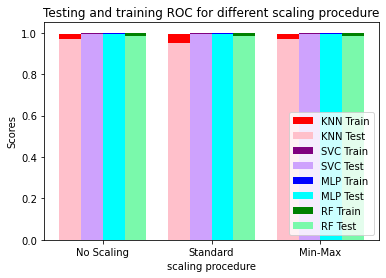

In [41]:
#Visualize the scaling and ROC for each algorithm
labels = ['No Scaling', 'Standard','Min-Max']

KNN_train_scores = (0.996, 0.993, 0.995)
KNN_test_scores = (0.970, 0.950, 0.971)
SVC_train_scores = (0.999, 0.999, 1.0)
SVC_test_scores = (0.995, 0.992, 0.995)
MLP_train_scores = (1.0, 1.0, 1.0)
MLP_test_scores = (0.996, 0.996, 0.996)
RF_train_scores = (1.0,1.0, 1.0)
RF_test_scores = (0.982, 0.982, 0.982)

x = np.arange(len(labels))  # the label locations
width = .2  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - 3*width/2, KNN_train_scores, width, label='KNN Train', color='red')
rects2 = ax.bar(x - 3*width/2, KNN_test_scores, width, label='KNN Test', color='pink') 
rects1 = ax.bar(x - width/2, SVC_train_scores, width, label='SVC Train', color='purple')
rects2 = ax.bar(x - width/2, SVC_test_scores, width, label='SVC Test', color='#cea2fd') 
rects1 = ax.bar(x + width/2, MLP_train_scores, width, label='MLP Train', color='blue')
rects2 = ax.bar(x + width/2, MLP_test_scores, width, label='MLP Test', color= 'cyan') 
rects1 = ax.bar(x + 3*width/2, RF_train_scores, width, label='RF Train', color='green')
rects2 = ax.bar(x + 3*width/2, RF_test_scores, width, label='RF Test', color='#7af9ab') 

plt.xlabel('scaling procedure')
plt.ylabel('Scores')
plt.title('Testing and training ROC for different scaling procedure')

plt.xticks(x, labels)
plt.legend(loc=4)
plt.show()

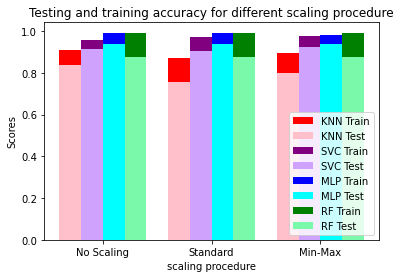

In [42]:
#Visualize the scaling and accuracy for each algorithm
labels = ['No Scaling', 'Standard','Min-Max']

KNN_train_scores = (0.911, 0.870, 0.895)
KNN_test_scores = (0.838, 0.757, 0.797)
SVC_train_scores = (0.958, 0.970, 0.974)
SVC_test_scores = (0.914, 0.905, 0.923)
MLP_train_scores = (0.992, 0.990, 0.982)
MLP_test_scores = (0.937, 0.937, 0.937)
RF_train_scores = (0.992,0.992, 0.992)
RF_test_scores = (0.874, 0.874, 0.874)

x = np.arange(len(labels))  # the label locations
width = .2  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - 3*width/2, KNN_train_scores, width, label='KNN Train', color='red')
rects2 = ax.bar(x - 3*width/2, KNN_test_scores, width, label='KNN Test', color='pink') 
rects1 = ax.bar(x - width/2, SVC_train_scores, width, label='SVC Train', color='purple')
rects2 = ax.bar(x - width/2, SVC_test_scores, width, label='SVC Test', color='#cea2fd') 
rects1 = ax.bar(x + width/2, MLP_train_scores, width, label='MLP Train', color='blue')
rects2 = ax.bar(x + width/2, MLP_test_scores, width, label='MLP Test', color= 'cyan') 
rects1 = ax.bar(x + 3*width/2, RF_train_scores, width, label='RF Train', color='green')
rects2 = ax.bar(x + 3*width/2, RF_test_scores, width, label='RF Test', color='#7af9ab') 

plt.xlabel('scaling procedure')
plt.ylabel('Scores')
plt.title('Testing and training accuracy for different scaling procedure')

plt.xticks(x, labels)
plt.legend(loc=4)
plt.show()

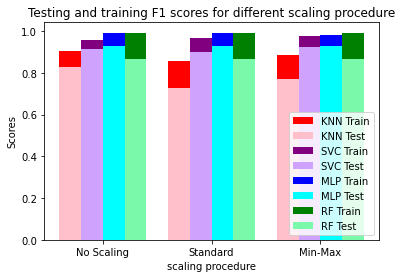

In [43]:
#Visualize the scaling and F1 score for each algorithm
labels = ['No Scaling', 'Standard','Min-Max']

KNN_train_scores = (0.905, 0.858, 0.886)
KNN_test_scores = (0.826, 0.727, 0.772)
SVC_train_scores = (0.958, 0.969, 0.975)
SVC_test_scores = (0.914, 0.898, 0.922)
MLP_train_scores = (0.992, 0.990, 0.980)
MLP_test_scores = (0.928, 0.927, 0.928)
RF_train_scores = (0.992,0.992, 0.992)
RF_test_scores = (0.864, 0.864, 0.864)

x = np.arange(len(labels))  # the label locations
width = .2  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - 3*width/2, KNN_train_scores, width, label='KNN Train', color='red')
rects2 = ax.bar(x - 3*width/2, KNN_test_scores, width, label='KNN Test', color='pink') 
rects1 = ax.bar(x - width/2, SVC_train_scores, width, label='SVC Train', color='purple')
rects2 = ax.bar(x - width/2, SVC_test_scores, width, label='SVC Test', color='#cea2fd') 
rects1 = ax.bar(x + width/2, MLP_train_scores, width, label='MLP Train', color='blue')
rects2 = ax.bar(x + width/2, MLP_test_scores, width, label='MLP Test', color= 'cyan') 
rects1 = ax.bar(x + 3*width/2, RF_train_scores, width, label='RF Train', color='green')
rects2 = ax.bar(x + 3*width/2, RF_test_scores, width, label='RF Test', color='#7af9ab') 

plt.xlabel('scaling procedure')
plt.ylabel('Scores')
plt.title('Testing and training F1 scores for different scaling procedure')

plt.xticks(x, labels)
plt.legend(loc=4)
plt.show()

# PCA

In [44]:
scaler = MinMaxScaler().fit(X_train)
#scale the data
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

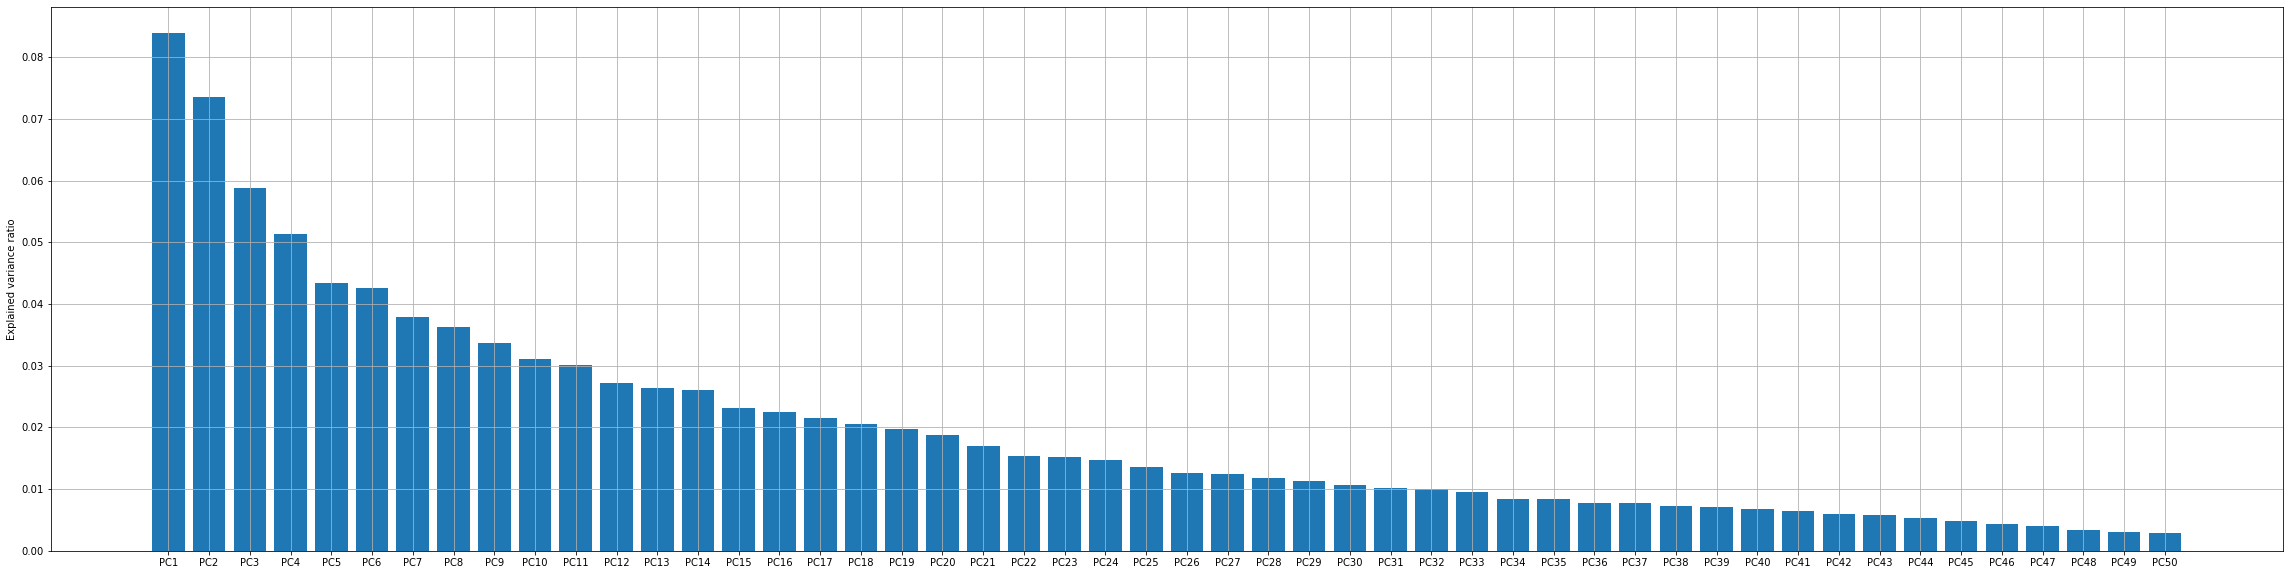

In [45]:
#PCA with 50 components
pca = PCA(n_components=50).fit(X_train_s)
explained_var = pca.explained_variance_ratio_

#plot explained variance
plt.figure(figsize=(40,10))
plt.bar(["PC{}".format(i) for i in range(1,len(explained_var)+1)], pca.explained_variance_ratio_)
plt.ylabel("Explained variance ratio")
plt.grid()

In [46]:
pca = PCA(n_components=41).fit(X_train_s)
explained_var = pca.explained_variance_ratio_
print("Explained variance = ", sum(explained_var))

Explained variance =  0.9532210280772616


In [47]:
pca = PCA(n_components=49).fit(X_train_s)
explained_var = pca.explained_variance_ratio_
print("Explained variance = ", sum(explained_var))

Explained variance =  0.9901026561051776


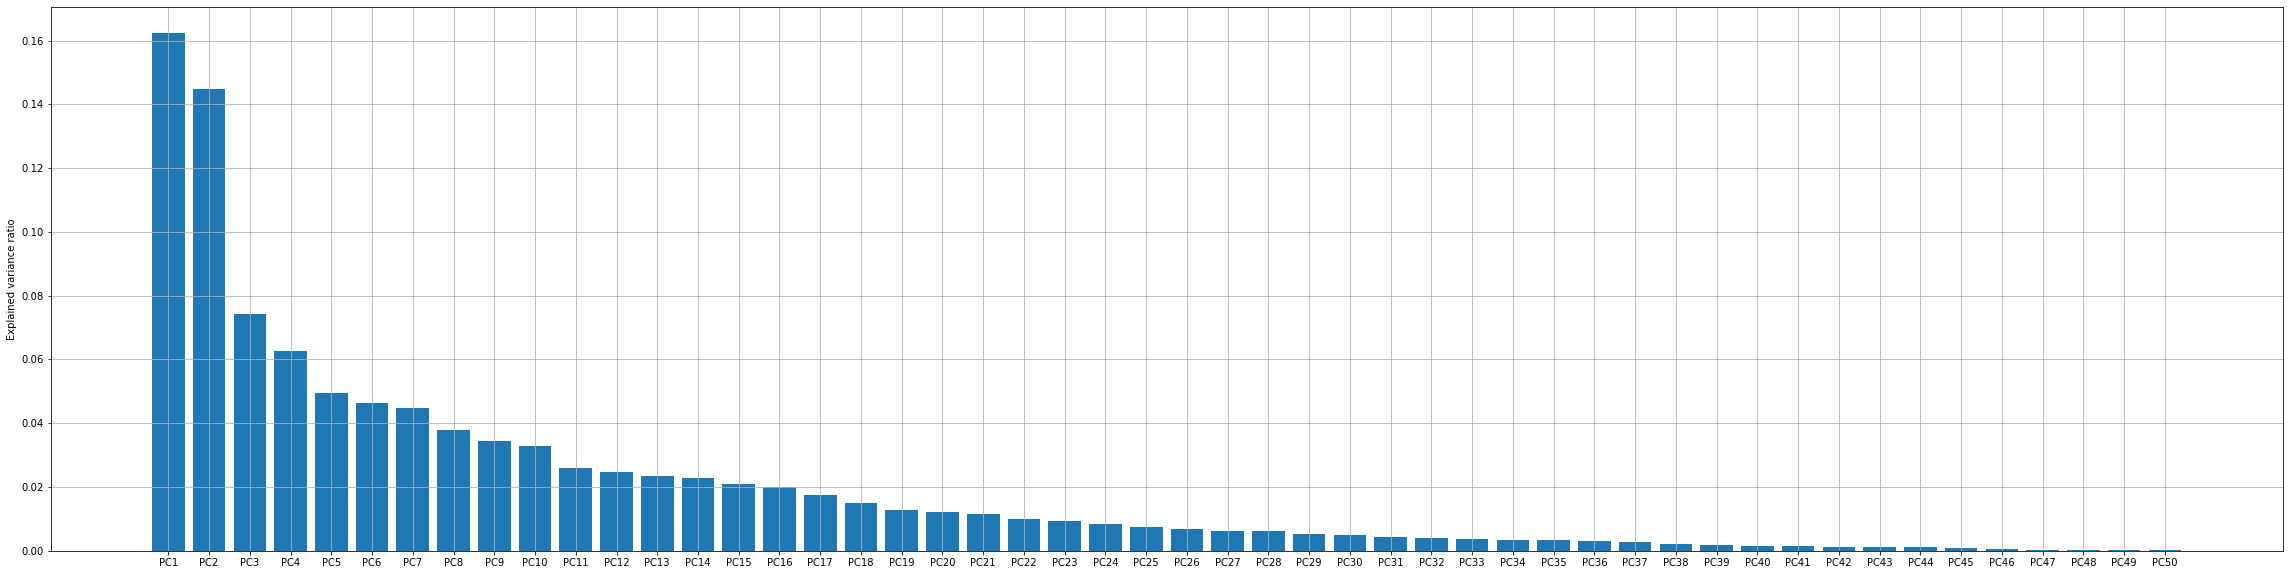

In [48]:
#PCA with 50 components
pca = PCA(n_components=50).fit(X_train)
explained_var = pca.explained_variance_ratio_

#plot explained variance
plt.figure(figsize=(40,10))
plt.bar(["PC{}".format(i) for i in range(1,len(explained_var)+1)], pca.explained_variance_ratio_)
plt.ylabel("Explained variance ratio")
plt.grid()

In [49]:
pca = PCA(n_components=28).fit(X_train)
explained_var = pca.explained_variance_ratio_
print("Explained variance = ", sum(explained_var))

Explained variance =  0.9518795737517113


In [50]:
pca = PCA(n_components=39).fit(X_train)
explained_var = pca.explained_variance_ratio_
print("Explained variance = ", sum(explained_var))

Explained variance =  0.9910779445642497


### KNN

In [51]:
# KNN pipe
pca = PCA()
pipe_knn_pca = Pipeline([('scaling', None),
                         ('pca', pca), 
                         ('clf', KNeighborsClassifier())])
params_knn_pca = [{'pca__n_components': [28, 39]}]

In [52]:
#gridsearch with KNN PCA and accuracy

gs_knn_pca = GridSearchCV(estimator=pipe_knn_pca,
      param_grid=params_knn_pca,
      scoring='accuracy',
      cv=4, refit=True)
 
gs_knn_pca.fit(X_train, y_train)

print('Training accuracy : %.3f'%gs_knn_pca.score(X_train, y_train))
print('Testing accuracy : %.3f'%gs_knn_pca.score(X_test, y_test))
print('Best Parameters : ',gs_knn_pca.best_params_)
#print('All results : ',pd.DataFrame(gs_knn_pca.cv_results_))

Training accuracy : 0.909
Testing accuracy : 0.833
Best Parameters :  {'pca__n_components': 39}


In [53]:
#PCA gridsearch with KNN and F1 score

gs_knn_pca = GridSearchCV(estimator=pipe_knn_pca,
      param_grid=params_knn_pca,
      scoring=f1,
      cv=4)
 
gs_knn_pca.fit(X_train, y_train)
print('Training F1 : %.3f'%gs_knn_pca.score(X_train, y_train))
print('Testing F1 : %.3f'%gs_knn_pca.score(X_test, y_test))
print('Best Parameters : ',gs_knn_pca.best_params_)
#print('All results : ',pd.DataFrame(gs_knn_pca.cv_results_))

Training F1 : 0.902
Testing F1 : 0.822
Best Parameters :  {'pca__n_components': 39}


In [54]:
#PCA pipe with KNN and ROC
 
gs_knn_pca = GridSearchCV(estimator=pipe_knn_pca,
                          param_grid=params_knn_pca,
                          cv=4,
                          scoring='roc_auc_ovr')
 
gs_knn_pca.fit(X_train, y_train)
print('Training ROC : %.3f'%gs_knn_pca.score(X_train, y_train))
print('Testing ROC : %.3f'%gs_knn_pca.score(X_test, y_test))
print('Best Parameters : ',gs_knn_pca.best_params_)
#print('All results : ',pd.DataFrame(gs_knn_pca.cv_results_))

Training ROC : 0.996
Testing ROC : 0.964
Best Parameters :  {'pca__n_components': 39}


### SVC

In [55]:
#PCA pipe with SVC
pca = PCA()

pipe_svc_pca = Pipeline(steps=[('scaling',MinMaxScaler()),('pca', pca), ('clf', SVC(random_state=0,probability=True))])
 
params_svc_pca =  [{'pca__n_components': [41, 49]}]

In [56]:
#PCA gridsearch with SVC and accuracy

gs_svc_pca = GridSearchCV(estimator=pipe_svc_pca,
      param_grid=params_svc_pca,
      scoring='accuracy',
      cv=4)
 
gs_svc_pca.fit(X_train, y_train)

print('Train Accuracy : %.3f'%gs_svc_pca.score(X_train, y_train))
print('Test Accuracy : %.3f'%gs_svc_pca.score(X_test, y_test))
print('Best Parameters : ',gs_svc_pca.best_params_)
#print('All results : ',pd.DataFrame(gs_svc_pca.cv_results_))

Train Accuracy : 0.972
Test Accuracy : 0.923
Best Parameters :  {'pca__n_components': 49}


In [57]:
#PCA pipe with SVC and F1 score
gs_svc_pca = GridSearchCV(estimator=pipe_svc_pca,
      param_grid=params_svc_pca,
      scoring=f1,
      cv=4)
 
gs_svc_pca.fit(X_train, y_train)

print('Train F1 score : %.3f'%gs_svc_pca.score(X_train, y_train))
print('Test F1 score : %.3f'%gs_svc_pca.score(X_test, y_test))
print('Best Parameters : ',gs_svc_pca.best_params_)
#print('All results : ',pd.DataFrame(gs_svc_pca.cv_results_))

Train F1 score : 0.973
Test F1 score : 0.922
Best Parameters :  {'pca__n_components': 49}


In [58]:
#PCA pipe with SVC and ROC
gs_svc_pca = GridSearchCV(estimator=pipe_svc_pca,
      param_grid=params_svc_pca,
      scoring='roc_auc_ovr',
      cv=4)
 
gs_svc_pca.fit(X_train, y_train)

print('Train ROC : %.3f'%gs_svc_pca.score(X_train, y_train))
print('Test ROC : %.3f'%gs_svc_pca.score(X_test, y_test))
print('Best Parameters : ',gs_svc_pca.best_params_)
#print('All results : ',pd.DataFrame(gs_svc_pca.cv_results_))

Train ROC : 1.000
Test ROC : 0.994
Best Parameters :  {'pca__n_components': 49}


### MLP

In [59]:
#PCA pipe with MLP
pca = PCA()

pipe_mlp_pca = Pipeline(steps=[('scaling',MinMaxScaler()),('pca', pca), ('clf', MLPClassifier(random_state=0))])


params_mlp_pca = [{'pca__n_components': [41, 49]}]

In [60]:
#PCA pipe with MLP and accuracy

gs_mlp_pca = GridSearchCV(estimator=pipe_mlp_pca,
                          param_grid=params_mlp_pca,
                          scoring='accuracy',
                          cv=4)
 
gs_mlp_pca.fit(X_train, y_train)

print('Train accuracy : %.3f'%gs_mlp_pca.score(X_train, y_train))
print('Test accuracy : %.3f'%gs_mlp_pca.score(X_test, y_test))
print('Best Parameters : ',gs_mlp_pca.best_params_)
#print('All results : ',pd.DataFrame(gs_mlp_pca.cv_results_))

Train accuracy : 0.982
Test accuracy : 0.941
Best Parameters :  {'pca__n_components': 49}


In [61]:
#PCA pipe with MLP and F1 score
 
gs_mlp_pca = GridSearchCV(estimator=pipe_mlp_pca,
      param_grid=params_mlp_pca,
      scoring=f1,
      cv=4)
 
gs_mlp_pca.fit(X_train, y_train)

print('Train F1 score : %.3f'%gs_mlp_pca.score(X_train, y_train))
print('Test F1 score : %.3f'%gs_mlp_pca.score(X_test, y_test))
print('Best Parameters : ',gs_mlp_pca.best_params_)
#print('All results : ',pd.DataFrame(gs_mlp_pca.cv_results_))

Train F1 score : 0.980
Test F1 score : 0.937
Best Parameters :  {'pca__n_components': 49}


In [62]:
#PCA pipe with MLP and ROC score
 
gs_mlp_pca = GridSearchCV(estimator=pipe_mlp_pca,
      param_grid=params_mlp_pca,
      scoring='roc_auc_ovr',
      cv=4)
 
gs_mlp_pca.fit(X_train, y_train)

print('Train ROC : %.3f'%gs_mlp_pca.score(X_train, y_train))
print('Test ROC : %.3f'%gs_mlp_pca.score(X_test, y_test))
print('Best Parameters : ',gs_mlp_pca.best_params_)
#print('All results : ',pd.DataFrame(gs_mlp_pca.cv_results_))

Train ROC : 1.000
Test ROC : 0.997
Best Parameters :  {'pca__n_components': 41}


### RF

In [63]:
#PCA pipe with RF 
pca = PCA()
pipe_rf_pca = Pipeline(steps=[('scaling',None),('pca', pca), ('clf', RandomForestClassifier(random_state=0))])
 
params_rf_pca = [{'pca__n_components': [28, 39]}]

In [64]:
#PCA pipe with RF and accuracy score
gs_rf_pca = GridSearchCV(estimator=pipe_rf_pca,
      param_grid=params_rf_pca,
      scoring='accuracy',
      cv=4)
 
gs_rf_pca.fit(X_train, y_train)
print('Train Accuracy : %.3f'%gs_rf_pca.score(X_train, y_train))
print('Test Accuracy : %.3f'%gs_rf_pca.score(X_test, y_test))
print('Best Parameters : ',gs_rf_pca.best_params_)
#print('All results : ',pd.DataFrame(gs_rf_pca.cv_results_))

Train Accuracy : 0.992
Test Accuracy : 0.824
Best Parameters :  {'pca__n_components': 28}


In [65]:
#PCA pipe with RF and F1 score
 
gs_rf_pca = GridSearchCV(estimator=pipe_rf_pca,
      param_grid=params_rf_pca,
      scoring=f1,
      cv=4)
 
gs_rf_pca.fit(X_train, y_train)
print('Train F1 score : %.3f'%gs_rf_pca.score(X_train, y_train))
print('Test F1 score : %.3f'%gs_rf_pca.score(X_test, y_test))
print('Best Parameters : ',gs_rf_pca.best_params_)
#print('All results : ',pd.DataFrame(gs_rf_pca.cv_results_))

Train F1 score : 0.992
Test F1 score : 0.814
Best Parameters :  {'pca__n_components': 39}


In [66]:
#PCA pipe with RF and ROC score
 
gs_rf_pca = GridSearchCV(estimator=pipe_rf_pca,
      param_grid=params_rf_pca,
      scoring='roc_auc_ovr',
      cv=4)
 
gs_rf_pca.fit(X_train, y_train)
print('Train ROC : %.3f'%gs_rf_pca.score(X_train, y_train))
print('Test ROC : %.3f'%gs_rf_pca.score(X_test, y_test))
print('Best Parameters : ',gs_rf_pca.best_params_)
#print('All results : ',pd.DataFrame(gs_rf_pca.cv_results_))

Train ROC : 1.000
Test ROC : 0.981
Best Parameters :  {'pca__n_components': 39}


# Feature selection

In [67]:
#ANOVA - measures the linear dependence between the features and the class labels
from sklearn.feature_selection import f_classif
f, p = f_classif (X_train, y_train)

In [68]:
#mutual information
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(X_train, y_train)

In [69]:
#pd.DataFrame({'F': f,'MI': mi,}).sort_values('MI', ascending=False).style.bar(subset=['F', 'MI'], color='grey')

In [70]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

## KNN Feature Selection

In [71]:
#KNN pipe for feature selection
pipe_knn = Pipeline(steps=[('scaling',None),
                            ('skb', SelectKBest(f_classif,)),
                           ('clf', KNeighborsClassifier())])

params_knn = [{'skb__k':[40,45,50]}]

In [72]:
#Feature selection pipe with knn and accuracy

gs_knn = GridSearchCV(estimator=pipe_knn,
                          param_grid=params_knn,
                          scoring='accuracy',
                          cv=4)
 
gs_knn.fit(X_train, y_train)

print('Train accuracy : %.3f'%gs_knn.score(X_train, y_train))
print('Test accuracy : %.3f'%gs_knn.score(X_test, y_test))
print('Best Parameters : ',gs_knn.best_params_)
#print('All results : ',pd.DataFrame(gs_knn.cv_results_))

Train accuracy : 0.911
Test accuracy : 0.838
Best Parameters :  {'skb__k': 50}


In [73]:
#Feature selection pipe with knn and F1

gs_knn = GridSearchCV(estimator=pipe_knn,
                          param_grid=params_knn,
                          scoring=f1,
                          cv=4)
 
gs_knn.fit(X_train, y_train)

print('Train F1 score : %.3f'%gs_knn.score(X_train, y_train))
print('Test F1 score : %.3f'%gs_knn.score(X_test, y_test))
print('Best Parameters : ',gs_knn.best_params_)
#print('All results : ',pd.DataFrame(gs_knn.cv_results_))

Train F1 score : 0.905
Test F1 score : 0.826
Best Parameters :  {'skb__k': 50}


In [74]:
#Feature selection pipe with knn and ROC

gs_knn = GridSearchCV(estimator=pipe_knn,
                          param_grid=params_knn,
                          scoring='roc_auc_ovr',
                          cv=4)
 
gs_knn.fit(X_train, y_train)

print('Train ROC : %.3f'%gs_knn.score(X_train, y_train))
print('Test ROC : %.3f'%gs_knn.score(X_test, y_test))
print('Best Parameters : ',gs_knn.best_params_)
#print('All results : ',pd.DataFrame(gs_knn.cv_results_))

Train ROC : 0.996
Test ROC : 0.970
Best Parameters :  {'skb__k': 50}


## KNN Feature Selection and PCA

In [75]:
# Feature selection and PCA pipe with KNN
pca = PCA()
pipe_knn_pca = Pipeline(steps=[('skb', SelectKBest(f_classif,)),
                               ('scaling',None),
                              ('pca', pca), 
                              ('clf', KNeighborsClassifier())])
 
params_knn_pca = [{'skb__k':[40,45,50],
                 'pca__n_components': [28,39]}]

In [76]:
# Feature selection and PCA pipe with KNN and accuracy score

 
gs_knn_pca = GridSearchCV(estimator=pipe_knn_pca,
      param_grid=params_knn_pca,
      scoring='accuracy',
      cv=4)
 
gs_knn_pca.fit(X_train, y_train)
print('Train Accuracy : %.3f'%gs_knn_pca.score(X_train, y_train))
print('Test Accuracy : %.3f'%gs_knn_pca.score(X_test, y_test))
print('Best Parameters : ',gs_knn_pca.best_params_)
#print('All results : ',pd.DataFrame(gs_knn_pca.cv_results_))

Train Accuracy : 0.909
Test Accuracy : 0.833
Best Parameters :  {'pca__n_components': 39, 'skb__k': 50}


In [77]:
# Feature selection and PCA pipe with KNN and F1
 
gs_knn_pca = GridSearchCV(estimator=pipe_knn_pca,
      param_grid=params_knn_pca,
      scoring=f1,
      cv=4)
 
gs_knn_pca.fit(X_train, y_train)
print('Train F1 : %.3f'%gs_knn_pca.score(X_train, y_train))
print('Test F1 : %.3f'%gs_knn_pca.score(X_test, y_test))
print('Best Parameters : ',gs_knn_pca.best_params_)
#print('All results : ',pd.DataFrame(gs_knn_pca.cv_results_))

Train F1 : 0.902
Test F1 : 0.831
Best Parameters :  {'pca__n_components': 39, 'skb__k': 45}


In [78]:
# Feature selection and PCA pipe with KNN and ROC
 
gs_knn_pca = GridSearchCV(estimator=pipe_knn_pca,
      param_grid=params_knn_pca,
      scoring='roc_auc_ovr',
      cv=4)
 
gs_knn_pca.fit(X_train, y_train)
print('Train ROC : %.3f'%gs_knn_pca.score(X_train, y_train))
print('Test ROC : %.3f'%gs_knn_pca.score(X_test, y_test))
print('Best Parameters : ',gs_knn_pca.best_params_)
#print('All results : ',pd.DataFrame(gs_knn_pca.cv_results_))

Train ROC : 0.996
Test ROC : 0.964
Best Parameters :  {'pca__n_components': 39, 'skb__k': 50}


## SVC Feature selection

In [79]:
# svc pipe
pipe_svc = Pipeline(steps=[('skb', SelectKBest(f_classif,)),
                           ('scaling',MinMaxScaler()),
                               ('clf', SVC(random_state=0,probability=True))])

params_svc = [{'skb__k':[40,45,50]}]

In [80]:
#Feature selection pipe with svc and accuracy

gs_svc = GridSearchCV(estimator=pipe_svc,
                          param_grid=params_svc,
                          scoring='accuracy',
                          cv=4)
 
gs_svc.fit(X_train, y_train)

print('Train accuracy : %.3f'%gs_svc.score(X_train, y_train))
print('Test accuracy : %.3f'%gs_svc.score(X_test, y_test))
print('Best Parameters : ',gs_svc.best_params_)
#print('All results : ',pd.DataFrame(gs_svc.cv_results_))

Train accuracy : 0.974
Test accuracy : 0.923
Best Parameters :  {'skb__k': 50}


In [81]:
#Feature selection pipe with svc and F1

gs_svc = GridSearchCV(estimator=pipe_svc,
                          param_grid=params_svc,
                          scoring=f1,
                          cv=4)
 
gs_svc.fit(X_train, y_train)

print('Train F1 : %.3f'%gs_svc.score(X_train, y_train))
print('Test F1 : %.3f'%gs_svc.score(X_test, y_test))
print('Best Parameters : ',gs_svc.best_params_)
#print('All results : ',pd.DataFrame(gs_svc.cv_results_))

Train F1 : 0.975
Test F1 : 0.922
Best Parameters :  {'skb__k': 50}


In [82]:
#Feature selection pipe with svc and ROC

gs_svc = GridSearchCV(estimator=pipe_svc,
                          param_grid=params_svc,
                          scoring='roc_auc_ovr',
                          cv=4)
 
gs_svc.fit(X_train, y_train)

print('Train ROC : %.3f'%gs_svc.score(X_train, y_train))
print('Test ROC : %.3f'%gs_svc.score(X_test, y_test))
print('Best Parameters : ',gs_svc.best_params_)
#print('All results : ',pd.DataFrame(gs_svc.cv_results_))

Train ROC : 1.000
Test ROC : 0.995
Best Parameters :  {'skb__k': 50}


## SVM Feature selection and PCA

In [83]:
#SVC pipe
pca = PCA()
pipe_svc_pca = Pipeline(steps=[('skb', SelectKBest(f_classif,)),
                               ('scaling',MinMaxScaler()),
                              ('pca', pca),  
                              ('clf', SVC(random_state=0,probability=True))])
 
params_svc_pca = [{'skb__k':[40,45,50],
                 'pca__n_components': [41,49]}]

In [84]:
# Feature selection and PCA pipe with svc and accuracy score

 
gs_svc_pca = GridSearchCV(estimator=pipe_svc_pca,
      param_grid=params_svc_pca,
      scoring='accuracy',
      cv=4)
 
gs_svc_pca.fit(X_train, y_train)
print('Train accuracy : %.3f'%gs_svc_pca.score(X_train, y_train))
print('Test accuracy : %.3f'%gs_svc_pca.score(X_test, y_test))
print('Best Parameters : ',gs_svc_pca.best_params_)
#print('All results : ',pd.DataFrame(gs_svc_pca.cv_results_))

Train accuracy : 0.974
Test accuracy : 0.923
Best Parameters :  {'pca__n_components': 49, 'skb__k': 50}


In [85]:
# Feature selection and PCA pipe with svc and F1

 
gs_svc_pca = GridSearchCV(estimator=pipe_svc_pca,
      param_grid=params_svc_pca,
      scoring=f1,
      cv=4)
 
gs_svc_pca.fit(X_train, y_train)
print('Train F1 : %.3f'%gs_svc_pca.score(X_train, y_train))
print('Test F1 : %.3f'%gs_svc_pca.score(X_test, y_test))
print('Best Parameters : ',gs_svc_pca.best_params_)
#print('All results : ',pd.DataFrame(gs_svc_pca.cv_results_))

Train F1 : 0.975
Test F1 : 0.922
Best Parameters :  {'pca__n_components': 49, 'skb__k': 50}


In [86]:
# Feature selection and PCA pipe with svc and ROC

 
gs_svc_pca = GridSearchCV(estimator=pipe_svc_pca,
      param_grid=params_svc_pca,
      scoring='roc_auc_ovr',
      cv=4)
 
gs_svc_pca.fit(X_train, y_train)
print('Train ROC : %.3f'%gs_svc_pca.score(X_train, y_train))
print('Test ROC : %.3f'%gs_svc_pca.score(X_test, y_test))
print('Best Parameters : ',gs_svc_pca.best_params_)
#print('All results : ',pd.DataFrame(gs_svc_pca.cv_results_))

Train ROC : 1.000
Test ROC : 0.994
Best Parameters :  {'pca__n_components': 41, 'skb__k': 50}


## MLP Feature Selection

In [87]:
pipe_mlp = Pipeline(steps=[('scaling',MinMaxScaler()),
                               ('skb', SelectKBest(f_classif,)),
                               ('clf', MLPClassifier(random_state=0))])

params_mlp = [{'skb__k':[40,45,50]}]

In [88]:
#Feature selection pipe with MLP and accuracy

gs_mlp = GridSearchCV(estimator=pipe_mlp,
                          param_grid=params_mlp,
                          scoring='accuracy',
                          cv=4)
 
gs_mlp.fit(X_train, y_train)

print('Train accuracy : %.3f'%gs_mlp.score(X_train, y_train))
print('Test accuracy : %.3f'%gs_mlp.score(X_test, y_test))
print('Best Parameters : ',gs_mlp.best_params_)
#print('All results : ',pd.DataFrame(gs_mlp.cv_results_))

Train accuracy : 0.982
Test accuracy : 0.937
Best Parameters :  {'skb__k': 50}


In [89]:
#Feature selection pipe with MLP and F1


gs_mlp = GridSearchCV(estimator=pipe_mlp,
                          param_grid=params_mlp,
                          scoring=f1,
                          cv=4)
 
gs_mlp.fit(X_train, y_train)

print('Train F1 : %.3f'%gs_mlp.score(X_train, y_train))
print('Test F1 : %.3f'%gs_mlp.score(X_test, y_test))
print('Best Parameters : ',gs_mlp.best_params_)
#print('All results : ',pd.DataFrame(gs_mlp.cv_results_))

Train F1 : 0.980
Test F1 : 0.931
Best Parameters :  {'skb__k': 50}


In [90]:
#Feature selection pipe with MLP and ROC

gs_mlp = GridSearchCV(estimator=pipe_mlp,
                          param_grid=params_mlp,
                          scoring='roc_auc_ovr',
                          cv=4)
 
gs_mlp.fit(X_train, y_train)

print('Train ROC : %.3f'%gs_mlp.score(X_train, y_train))
print('Test ROC : %.3f'%gs_mlp.score(X_test, y_test))
print('Best Parameters : ',gs_mlp.best_params_)
#print('All results : ',pd.DataFrame(gs_mlp.cv_results_))

Train ROC : 1.000
Test ROC : 0.996
Best Parameters :  {'skb__k': 50}


## MLP Feature selection and PCA

In [91]:
#MLP pipe
pca = PCA()
pipe_mlp_pca = Pipeline(steps=[('skb', SelectKBest(f_classif,)),
                               ('scaling',MinMaxScaler()),
                              ('pca', pca),  
                              ('clf', MLPClassifier(random_state=0))])
 
params_mlp_pca = [{'skb__k':[40,45,50],
                 'pca__n_components': [41,49]}]

In [92]:
# Feature selection and PCA pipe with RF and accuracy score

 
gs_mlp_pca = GridSearchCV(estimator=pipe_mlp_pca,
      param_grid=params_mlp_pca,
      scoring='accuracy',
      cv=4)
 
gs_mlp_pca.fit(X_train, y_train)
print('Train Accuracy : %.3f'%gs_mlp_pca.score(X_train, y_train))
print('Test Accuracy : %.3f'%gs_mlp_pca.score(X_test, y_test))
print('Best Parameters : ',gs_mlp_pca.best_params_)
#print('All results : ',pd.DataFrame(gs_mlp_pca.cv_results_))

Train Accuracy : 0.984
Test Accuracy : 0.937
Best Parameters :  {'pca__n_components': 49, 'skb__k': 50}


In [93]:
# Feature selection and PCA pipe with RF and F1

 
gs_mlp_pca = GridSearchCV(estimator=pipe_mlp_pca,
      param_grid=params_mlp_pca,
      scoring=f1,
      cv=4)
 
gs_mlp_pca.fit(X_train, y_train)
print('Train F1 : %.3f'%gs_mlp_pca.score(X_train, y_train))
print('Test F1 : %.3f'%gs_mlp_pca.score(X_test, y_test))
print('Best Parameters : ',gs_mlp_pca.best_params_)
#print('All results : ',pd.DataFrame(gs_mlp_pca.cv_results_))

Train F1 : 0.983
Test F1 : 0.931
Best Parameters :  {'pca__n_components': 49, 'skb__k': 50}


In [94]:
# Feature selection and PCA pipe with RF and ROC

 
gs_mlp_pca = GridSearchCV(estimator=pipe_mlp_pca,
      param_grid=params_mlp_pca,
      scoring='roc_auc_ovr',
      cv=4)
 
gs_mlp_pca.fit(X_train, y_train)
print('Train ROC : %.3f'%gs_mlp_pca.score(X_train, y_train))
print('Test ROC : %.3f'%gs_mlp_pca.score(X_test, y_test))
print('Best Parameters : ',gs_mlp_pca.best_params_)
#print('All results : ',pd.DataFrame(gs_mlp_pca.cv_results_))

Train ROC : 1.000
Test ROC : 0.996
Best Parameters :  {'pca__n_components': 41, 'skb__k': 50}


## Random Forest Feature Selection

In [95]:
#Feature selection pipe with rf and accuracy

pipe_rf = Pipeline(steps=[('scaling',None),
                               ('skb', SelectKBest(f_classif,)),
                           ('clf', RandomForestClassifier(random_state=0))])

params_rf = [{'skb__k':[40,45,50]}]

In [96]:
#Feature selection pipe with rf and accuracy

gs_rf = GridSearchCV(estimator=pipe_rf,
                          param_grid=params_rf,
                          scoring='accuracy',
                          cv=4)
 
gs_rf.fit(X_train, y_train)

print('Train accuracy : %.3f'%gs_rf.score(X_train, y_train))
print('Test accuracy : %.3f'%gs_rf.score(X_test, y_test))
print('Best Parameters : ',gs_rf.best_params_)
#print('All results : ',pd.DataFrame(gs_rf.cv_results_))

Train accuracy : 0.992
Test accuracy : 0.874
Best Parameters :  {'skb__k': 50}


In [97]:
#Feature selection pipe with rf and f1

gs_rf = GridSearchCV(estimator=pipe_rf,
                          param_grid=params_rf,
                          scoring=f1,
                          cv=4)
 
gs_rf.fit(X_train, y_train)

print('Train F1 : %.3f'%gs_rf.score(X_train, y_train))
print('Test F1 : %.3f'%gs_rf.score(X_test, y_test))
print('Best Parameters : ',gs_rf.best_params_)
#print('All results : ',pd.DataFrame(gs_rf.cv_results_))

Train F1 : 0.992
Test F1 : 0.861
Best Parameters :  {'skb__k': 50}


In [98]:
#Feature selection pipe with rf and ROC

gs_rf = GridSearchCV(estimator=pipe_rf,
                          param_grid=params_rf,
                          scoring='roc_auc_ovr',
                          cv=4)
 
gs_rf.fit(X_train, y_train)

print('Train ROC : %.3f'%gs_rf.score(X_train, y_train))
print('Test ROC : %.3f'%gs_rf.score(X_test, y_test))
print('Best Parameters : ',gs_rf.best_params_)
#print('All results : ',pd.DataFrame(gs_rf.cv_results_))

Train ROC : 1.000
Test ROC : 0.979
Best Parameters :  {'skb__k': 40}


## Random Forest Feature selection and PCA

In [99]:
# Feature selection and PCA pipe with RF and accuracy score
pca = PCA()
pipe_rf_pca = Pipeline(steps=[('skb', SelectKBest(f_classif,)),
                               ('scaling',None),
                              ('pca', pca), 
                              ('clf', RandomForestClassifier(random_state=0))])
 
params_rf_pca = [{'skb__k':[40,45,50],
                 'pca__n_components': [28,39]}]

In [100]:
# Feature selection and PCA pipe with RF and accuracy score
 
gs_rf_pca = GridSearchCV(estimator=pipe_rf_pca,
      param_grid=params_rf_pca,
      scoring='accuracy',
      cv=4)
 
gs_rf_pca.fit(X_train, y_train)
print('Train Accuracy : %.3f'%gs_rf_pca.score(X_train, y_train))
print('Test Accuracy : %.3f'%gs_rf_pca.score(X_test, y_test))
print('Best Parameters : ',gs_rf_pca.best_params_)
#print('All results : ',pd.DataFrame(gs_rf_pca.cv_results_))

Train Accuracy : 0.992
Test Accuracy : 0.865
Best Parameters :  {'pca__n_components': 39, 'skb__k': 45}


In [101]:
# Feature selection and PCA pipe with RF and F1
 
gs_rf_pca = GridSearchCV(estimator=pipe_rf_pca,
      param_grid=params_rf_pca,
      scoring=f1,
      cv=4)
 
gs_rf_pca.fit(X_train, y_train)
print('Train F1 : %.3f'%gs_rf_pca.score(X_train, y_train))
print('Test F1 : %.3f'%gs_rf_pca.score(X_test, y_test))
print('Best Parameters : ',gs_rf_pca.best_params_)
#print('All results : ',pd.DataFrame(gs_rf_pca.cv_results_))

Train F1 : 0.992
Test F1 : 0.858
Best Parameters :  {'pca__n_components': 39, 'skb__k': 45}


In [102]:
# Feature selection and PCA pipe with RF and ROC
 
gs_rf_pca = GridSearchCV(estimator=pipe_rf_pca,
      param_grid=params_rf_pca,
      scoring='roc_auc_ovr',
      cv=4)
 
gs_rf_pca.fit(X_train, y_train)
print('Train ROC : %.3f'%gs_rf_pca.score(X_train, y_train))
print('Test ROC : %.3f'%gs_rf_pca.score(X_test, y_test))
print('Best Parameters : ',gs_rf_pca.best_params_)
#print('All results : ',pd.DataFrame(gs_rf_pca.cv_results_))

Train ROC : 1.000
Test ROC : 0.983
Best Parameters :  {'pca__n_components': 39, 'skb__k': 45}


## Hyperparameter tuning

### KNN

In [103]:
#KNN pipe
pca = PCA()
knn_pipe = Pipeline(steps=[('skb', SelectKBest(f_classif,)),
                               ('scaling',None),
                              ('pca', pca), 
                              ('clf', KNeighborsClassifier())])
#knn_pipe.get_params()

In [104]:
knn_params = [{'skb__k':[50],
               'pca__n_components': [39],
              'clf__n_neighbors':[10]}]

In [105]:
# Feature selection and PCA pipe with KNN and accuracy score
knn_gs = GridSearchCV(estimator=knn_pipe,
      param_grid=knn_params,
      scoring='accuracy',
      cv=4)
 
knn_gs.fit(X_train, y_train)
print('Train Accuracy : %.3f'%knn_gs.score(X_train, y_train))
print('Test Accuracy : %.3f'%knn_gs.score(X_test, y_test))
print('Best Parameters : ',knn_gs.best_params_)
#print('All results : ',pd.DataFrame(knn_gs.cv_results_))

Train Accuracy : 0.888
Test Accuracy : 0.838
Best Parameters :  {'clf__n_neighbors': 10, 'pca__n_components': 39, 'skb__k': 50}


In [106]:
# Feature selection and PCA pipe with KNN and accuracy score
knn_gs = GridSearchCV(estimator=knn_pipe,
      param_grid=knn_params,
      scoring=f1,
      cv=4)
 
knn_gs.fit(X_train, y_train)
print('Train F1 : %.3f'%knn_gs.score(X_train, y_train))
print('Test F1 : %.3f'%knn_gs.score(X_test, y_test))
print('Best Parameters : ',knn_gs.best_params_)
#print('All results : ',pd.DataFrame(knn_gs.cv_results_))

Train F1 : 0.883
Test F1 : 0.822
Best Parameters :  {'clf__n_neighbors': 10, 'pca__n_components': 39, 'skb__k': 50}


In [107]:
#fit data kbest=50 and pca=39
kbest = SelectKBest(f_classif,k=50).fit(X_train, y_train)
X_train_new=kbest.transform(X_train)
X_test_new=kbest.transform(X_test)
pca = PCA(n_components=39).fit(X_train)
pca.fit(X_train_new)
X_train_new = pca.transform(X_train_new)
X_test_new = pca.transform(X_test_new)

[Text(0.5, 0, 'number of neighbors'), Text(0, 0.5, 'F1')]

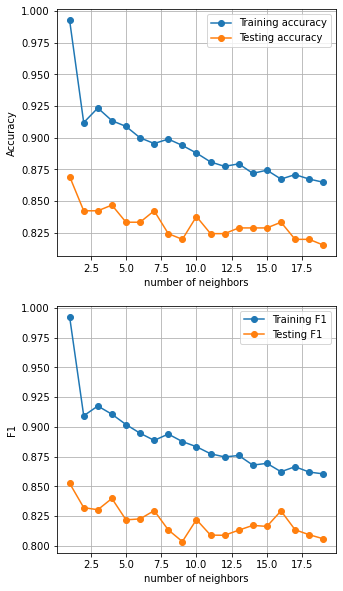

In [108]:
fig, axs = plt.subplots(2,1,figsize=(5,10))
acc_train = []
acc_test = []
for k in range(1, 20):
    clf = KNeighborsClassifier(n_neighbors=k).fit(X_train_new, y_train)
    acc_train.append(clf.score(X_train_new, y_train))
    acc_test.append(clf.score(X_test_new, y_test))
    
x_axis = range(1, 20)
axs[0].plot(x_axis,acc_train,'o-', label='Training accuracy')
axs[0].plot(x_axis,acc_test,'o-', label='Testing accuracy')
axs[0].grid()
axs[0].legend()
axs[0].set(xlabel='number of neighbors', ylabel='Accuracy')

f1_train = []
f1_test = []
for k in range(1, 20):
    clf = KNeighborsClassifier(n_neighbors=k).fit(X_train_new, y_train)
    f1_train.append(f1_score(y_train, clf.predict(X_train_new), average='macro'))
    f1_test.append(f1_score(y_test, clf.predict(X_test_new), average='macro'))
    
x_axis = range(1, 20)
axs[1].plot(x_axis,f1_train,'o-', label='Training F1')
axs[1].plot(x_axis,f1_test,'o-', label='Testing F1')
axs[1].grid()
axs[1].legend()
axs[1].set(xlabel='number of neighbors', ylabel='F1')

Train ROC : 0.994
Test ROC : 0.976
Best Parameters :  {'clf__n_neighbors': 10, 'pca__n_components': 39, 'skb__k': 50}


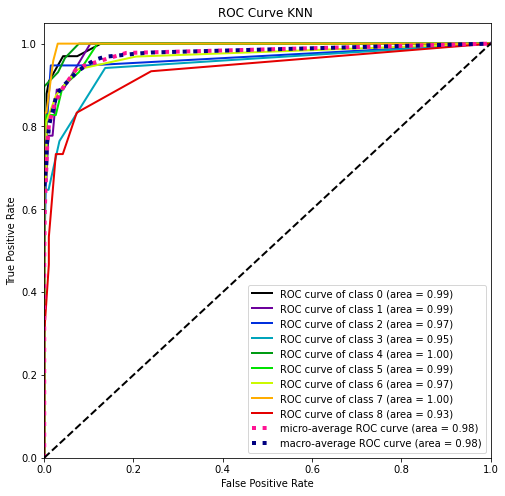

In [109]:
# Feature selection and PCA pipe with KNN and accuracy score
knn_gs = GridSearchCV(estimator=knn_pipe,
      param_grid=knn_params,
      scoring='roc_auc_ovr',
      cv=4)
 
knn_gs.fit(X_train, y_train)
print('Train ROC : %.3f'%knn_gs.score(X_train, y_train))
print('Test ROC : %.3f'%knn_gs.score(X_test, y_test))
print('Best Parameters : ',knn_gs.best_params_)
#print('All results : ',pd.DataFrame(knn_gs.cv_results_))
probas_knn_gs_roc = knn_gs.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, probas_knn_gs_roc,figsize=(8,8),title="ROC Curve KNN ")
plt.show()

### SVM

In [110]:
# svc pipe
pca = PCA()
pipe_svc = Pipeline(steps=[('skb', SelectKBest(f_classif,)),
                           ('scaling',MinMaxScaler()),
                           ('pca', pca), 
                               ('clf', SVC(random_state=0,probability=True))])

#pipe_svc.get_params()

In [111]:
#svc parameters
params_svc = [{'skb__k':[50],
               'pca__n_components': [49],
               'clf__C':[0.1, 0.2,0.4, 0.6],
               'clf__gamma':[0.01,0.1, 0.5,1.0]}]

In [112]:
#hyperparameter tuning with SVC

gs_svc = GridSearchCV(estimator=pipe_svc,
                          param_grid=params_svc,
                          scoring='accuracy',
                          cv=4)
 
gs_svc.fit(X_train, y_train)

print('Train accuracy : %.3f'%gs_svc.score(X_train, y_train))
print('Test accuracy : %.3f'%gs_svc.score(X_test, y_test))
print('Best Parameters : ',gs_svc.best_params_)
#print('All results : ',pd.DataFrame(gs_svc.cv_results_))

Train accuracy : 0.953
Test accuracy : 0.932
Best Parameters :  {'clf__C': 0.6, 'clf__gamma': 1.0, 'pca__n_components': 49, 'skb__k': 50}


In [113]:
#hyperparameter tuning with SVC

gs_svc = GridSearchCV(estimator=pipe_svc,
                          param_grid=params_svc,
                          scoring=f1,
                          cv=4)
 
gs_svc.fit(X_train, y_train)

print('Train F1 : %.3f'%gs_svc.score(X_train, y_train))
print('Test F1 : %.3f'%gs_svc.score(X_test, y_test))
print('Best Parameters : ',gs_svc.best_params_)
#print('All results : ',pd.DataFrame(gs_svc.cv_results_))

Train F1 : 0.953
Test F1 : 0.934
Best Parameters :  {'clf__C': 0.6, 'clf__gamma': 1.0, 'pca__n_components': 49, 'skb__k': 50}


In [114]:
scaler = MinMaxScaler().fit(X_train)
#scale the data
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)
#fit data kbest=50 and pca=39
kbest = SelectKBest(f_classif,k=50).fit(X_train_s, y_train)
X_train_new=kbest.transform(X_train_s)
X_test_new=kbest.transform(X_test_s)
pca = PCA(n_components=39).fit(X_train_new)
pca.fit(X_train_new)
X_train_new = pca.transform(X_train_new)
X_test_new = pca.transform(X_test_new)

[Text(0.5, 0, 'Gamma'), Text(0, 0.5, 'F1')]

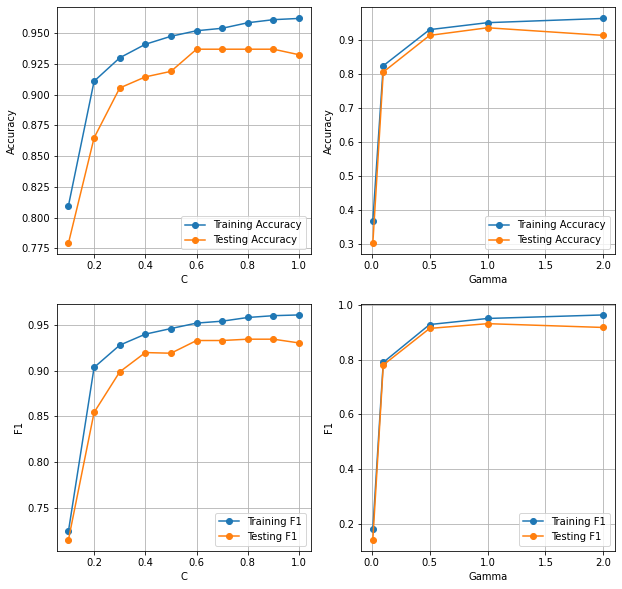

In [115]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
acc_train = []
acc_test = []
for c in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    clf = SVC(random_state=0,probability=True, C=c, gamma=1.0).fit(X_train_new, y_train)
    acc_train.append(clf.score(X_train_new, y_train))
    acc_test.append(clf.score(X_test_new, y_test))

x_axis = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
axs[0,0].plot(x_axis,acc_train,'o-', label='Training Accuracy')
axs[0,0].plot(x_axis,acc_test,'o-', label='Testing Accuracy')
axs[0,0].grid()
axs[0,0].legend()
axs[0,0].set(xlabel='C', ylabel='Accuracy')

acc_train = []
acc_test = []
for gam in [0.01,  0.1, 0.5,  1.0, 2.0]:
    clf = SVC(random_state=0,probability=True, C=0.6, gamma=gam).fit(X_train_new, y_train)
    acc_train.append(clf.score(X_train_new, y_train))
    acc_test.append(clf.score(X_test_new, y_test))
    
x_axis = [0.01,  0.1, 0.5,  1.0, 2.0]
axs[0,1].plot(x_axis,acc_train,'o-', label='Training Accuracy')
axs[0,1].plot(x_axis,acc_test,'o-', label='Testing Accuracy')
axs[0,1].grid()
axs[0,1].legend()
axs[0,1].set(xlabel='Gamma', ylabel='Accuracy')

f1_train = []
f1_test = []
for c in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    clf = SVC(random_state=0,probability=True, C=c, gamma=1.0).fit(X_train_new, y_train)
    f1_train.append(f1_score(y_train, clf.predict(X_train_new), average='macro'))
    f1_test.append(f1_score(y_test, clf.predict(X_test_new), average='macro'))

x_axis = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
axs[1,0].plot(x_axis,f1_train,'o-', label='Training F1')
axs[1,0].plot(x_axis,f1_test,'o-', label='Testing F1')
axs[1,0].grid()
axs[1,0].legend()
axs[1,0].set(xlabel='C', ylabel='F1')

f1_train = []
f1_test = []
for gam in [0.01,  0.1, 0.5,1.0, 2.0]:
    clf = SVC(random_state=0,probability=True, C=0.6, gamma=gam).fit(X_train_new, y_train)
    f1_train.append(f1_score(y_train, clf.predict(X_train_new), average='macro'))
    f1_test.append(f1_score(y_test, clf.predict(X_test_new), average='macro'))
    
x_axis = [0.01,  0.1, 0.5,  1.0, 2.0]
axs[1,1].plot(x_axis,f1_train,'o-', label='Training F1')
axs[1,1].plot(x_axis,f1_test,'o-', label='Testing F1')
axs[1,1].grid()
axs[1,1].legend()
axs[1,1].set(xlabel='Gamma', ylabel='F1')


Train ROC : 0.999
Test ROC : 0.996
Best Parameters :  {'clf__C': 0.6, 'clf__gamma': 1.0, 'pca__n_components': 49, 'skb__k': 50}


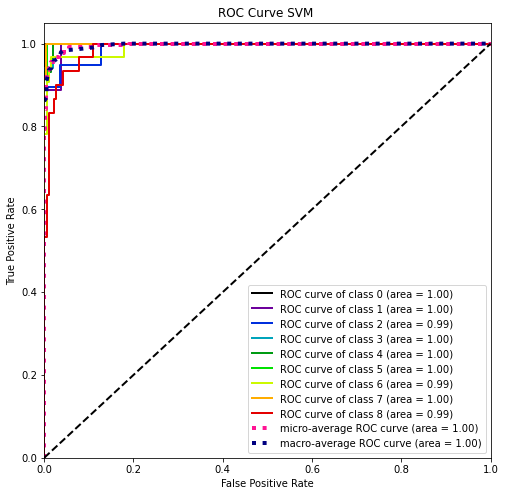

In [116]:
#hyperparameter tuning with SVC

gs_svc = GridSearchCV(estimator=pipe_svc,
                          param_grid=params_svc,
                          scoring='roc_auc_ovr',
                          cv=4)
 
gs_svc.fit(X_train, y_train)

print('Train ROC : %.3f'%gs_svc.score(X_train, y_train))
print('Test ROC : %.3f'%gs_svc.score(X_test, y_test))
print('Best Parameters : ',gs_svc.best_params_)
#print('All results : ',pd.DataFrame(gs_svc.cv_results_))
probas_gs_svc_roc = gs_svc.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, probas_gs_svc_roc,figsize=(8,8),title="ROC Curve SVM ")
plt.show()

### MLP

In [117]:
#mlp pipe
pca = PCA()
pipe_mlp_pca = Pipeline(steps=[('scaling',MinMaxScaler()),
                              ('pca', pca),  
                              ('clf', MLPClassifier(random_state=0))])
 
#pipe_mlp_pca.get_params()

In [118]:
params_mlp_pca = [{'pca__n_components': [49],
                 'clf__alpha':[0.001, 0.01,0.1, 0.5, 1.0],
          'clf__hidden_layer_sizes': [ (94,), (99,)]}]

In [119]:
gs_mlp_pca = GridSearchCV(estimator=pipe_mlp_pca,
      param_grid=params_mlp_pca,
      scoring='accuracy',
      cv=4)
 
gs_mlp_pca.fit(X_train, y_train)
print('Train Accuracy : %.3f'%gs_mlp_pca.score(X_train, y_train))
print('Test Accuracy : %.3f'%gs_mlp_pca.score(X_test, y_test))
print('Best Parameters : ',gs_mlp_pca.best_params_)
#print('All results : ',pd.DataFrame(gs_mlp_pca.cv_results_))

Train Accuracy : 0.982
Test Accuracy : 0.950
Best Parameters :  {'clf__alpha': 0.01, 'clf__hidden_layer_sizes': (94,), 'pca__n_components': 49}


In [120]:
gs_mlp_pca = GridSearchCV(estimator=pipe_mlp_pca,
      param_grid=params_mlp_pca,
      scoring=f1,
      cv=4)
 
gs_mlp_pca.fit(X_train, y_train)
print('Train F1 : %.3f'%gs_mlp_pca.score(X_train, y_train))
print('Test F1 : %.3f'%gs_mlp_pca.score(X_test, y_test))
print('Best Parameters : ',gs_mlp_pca.best_params_)
#print('All results : ',pd.DataFrame(gs_mlp_pca.cv_results_))

Train F1 : 0.980
Test F1 : 0.945
Best Parameters :  {'clf__alpha': 0.01, 'clf__hidden_layer_sizes': (94,), 'pca__n_components': 49}


Train ROC : 1.000
Test ROC : 0.997
Best Parameters :  {'clf__alpha': 0.01, 'clf__hidden_layer_sizes': (94,), 'pca__n_components': 49}


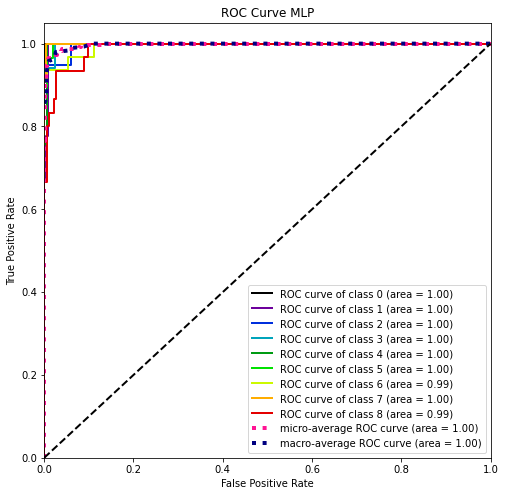

In [121]:
gs_mlp_pca = GridSearchCV(estimator=pipe_mlp_pca,
      param_grid=params_mlp_pca,
      scoring='roc_auc_ovr',
      cv=4)
 
gs_mlp_pca.fit(X_train, y_train)
print('Train ROC : %.3f'%gs_mlp_pca.score(X_train, y_train))
print('Test ROC : %.3f'%gs_mlp_pca.score(X_test, y_test))
print('Best Parameters : ',gs_mlp_pca.best_params_)
#print('All results : ',pd.DataFrame(gs_mlp_pca.cv_results_))
# plot the ROC curve
probas_mlp_pca_roc = gs_mlp_pca.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, probas_mlp_pca_roc,figsize=(8,8),title="ROC Curve MLP")
plt.show()

In [122]:
scaler = MinMaxScaler().fit(X_train)
#scale the data
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)
#fit data and pca=49
pca = PCA(n_components=49).fit(X_train_s)
X_train_new = pca.transform(X_train_s)
X_test_new = pca.transform(X_test_s)

[Text(0.5, 0, 'hidden_layer_sizes'), Text(0, 0.5, 'F1')]

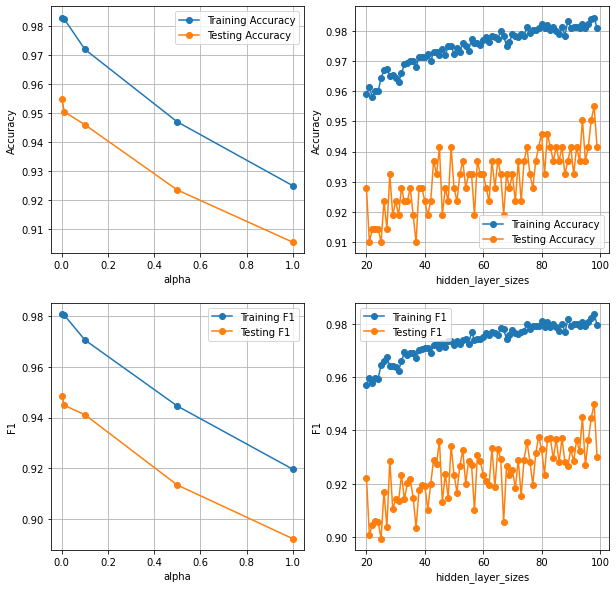

In [123]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
acc_train = []
acc_test = []
for alp in [0.001, 0.01,0.1, 0.5, 1.0]:
    clf =  MLPClassifier(random_state=0,alpha=alp, hidden_layer_sizes=(94,)).fit(X_train_new, y_train)
    acc_train.append(clf.score(X_train_new, y_train))
    acc_test.append(clf.score(X_test_new, y_test))

x_axis = [0.001, 0.01,0.1, 0.5, 1.0]
axs[0,0].plot(x_axis,acc_train,'o-', label='Training Accuracy')
axs[0,0].plot(x_axis,acc_test,'o-', label='Testing Accuracy')
axs[0,0].grid()
axs[0,0].legend()
axs[0,0].set(xlabel='alpha', ylabel='Accuracy')

acc_train = []
acc_test = []
for lay in range(20,100):
    clf =  MLPClassifier(random_state=0,alpha=0.01, hidden_layer_sizes=lay).fit(X_train_new, y_train)
    acc_train.append(clf.score(X_train_new, y_train))
    acc_test.append(clf.score(X_test_new, y_test))
    
x_axis = range(20,100)
axs[0,1].plot(x_axis,acc_train,'o-', label='Training Accuracy')
axs[0,1].plot(x_axis,acc_test,'o-', label='Testing Accuracy')
axs[0,1].grid()
axs[0,1].legend()
axs[0,1].set(xlabel='hidden_layer_sizes', ylabel='Accuracy')

f1_train = []
f1_test = []
for alp in [0.001, 0.01,0.1, 0.5, 1.0]:
    clf =  MLPClassifier(random_state=0,alpha=alp, hidden_layer_sizes=(94,)).fit(X_train_new, y_train)
    f1_train.append(f1_score(y_train, clf.predict(X_train_new), average='macro'))
    f1_test.append(f1_score(y_test, clf.predict(X_test_new), average='macro'))

x_axis = [0.001, 0.01,0.1, 0.5, 1.0]
axs[1,0].plot(x_axis,f1_train,'o-', label='Training F1')
axs[1,0].plot(x_axis,f1_test,'o-', label='Testing F1')
axs[1,0].grid()
axs[1,0].legend()
axs[1,0].set(xlabel='alpha', ylabel='F1')

f1_train = []
f1_test = []
for lay in range(20,100):
    clf =  MLPClassifier(random_state=0,alpha=0.01, hidden_layer_sizes=lay).fit(X_train_new, y_train)
    f1_train.append(f1_score(y_train, clf.predict(X_train_new), average='macro'))
    f1_test.append(f1_score(y_test, clf.predict(X_test_new), average='macro'))
    
x_axis = range(20,100)
axs[1,1].plot(x_axis,f1_train,'o-', label='Training F1')
axs[1,1].plot(x_axis,f1_test,'o-', label='Testing F1')
axs[1,1].grid()
axs[1,1].legend()
axs[1,1].set(xlabel='hidden_layer_sizes', ylabel='F1')


### RF

In [124]:
# RF Pipe
pipe_rf = Pipeline(steps=[('skb', SelectKBest(f_classif,)),
                               ('scaling',None), 
                              ('clf', RandomForestClassifier(random_state=0))])
#rf_pipe.get_params()

In [125]:
params_rf = [{'skb__k':[50],
              'clf__n_estimators': [42, 86],
              'clf__min_samples_leaf': [2, 5],
          'clf__max_depth': [10, 14]
             }]

In [126]:
#Feature selection pipe with rf and accuracy

gs_rf = GridSearchCV(estimator=pipe_rf,
                          param_grid=params_rf,
                          scoring='accuracy',
                          cv=4)
 
gs_rf.fit(X_train, y_train)

print('Train accuracy : %.3f'%gs_rf.score(X_train, y_train))
print('Test accuracy : %.3f'%gs_rf.score(X_test, y_test))
print('Best Parameters : ',gs_rf.best_params_)
#print('All results : ',pd.DataFrame(gs_rf.cv_results_))

Train accuracy : 0.982
Test accuracy : 0.892
Best Parameters :  {'clf__max_depth': 14, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 86, 'skb__k': 50}


In [127]:
#Feature selection pipe with rf and F1

gs_rf = GridSearchCV(estimator=pipe_rf,
                          param_grid=params_rf,
                          scoring=f1,
                          cv=4)
 
gs_rf.fit(X_train, y_train)

print('Train F1 : %.3f'%gs_rf.score(X_train, y_train))
print('Test F1 : %.3f'%gs_rf.score(X_test, y_test))
print('Best Parameters : ',gs_rf.best_params_)
#print('All results : ',pd.DataFrame(gs_rf.cv_results_))

Train F1 : 0.982
Test F1 : 0.886
Best Parameters :  {'clf__max_depth': 14, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 86, 'skb__k': 50}


Train ROC : 1.000
Test ROC : 0.985
Best Parameters :  {'clf__max_depth': 14, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 86, 'skb__k': 50}


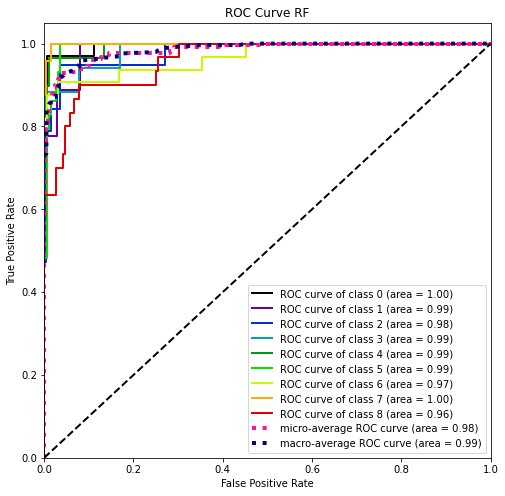

In [128]:
#Feature selection pipe with rf and ROC

gs_rf = GridSearchCV(estimator=pipe_rf,
                          param_grid=params_rf,
                          scoring='roc_auc_ovr',
                          cv=4)
 
gs_rf.fit(X_train, y_train)

print('Train ROC : %.3f'%gs_rf.score(X_train, y_train))
print('Test ROC : %.3f'%gs_rf.score(X_test, y_test))
print('Best Parameters : ',gs_rf.best_params_)
#print('All results : ',pd.DataFrame(gs_rf.cv_results_))
probas_gs_rf_roc = gs_rf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, probas_gs_rf_roc,figsize=(8,8),title="ROC Curve RF")
plt.show()

In [129]:
kbest = SelectKBest(f_classif,k=50).fit(X_train, y_train)
X_train_new=kbest.transform(X_train)
X_test_new=kbest.transform(X_test)

[Text(0.5, 0, 'min_samples_leaf'), Text(0, 0.5, 'F1')]

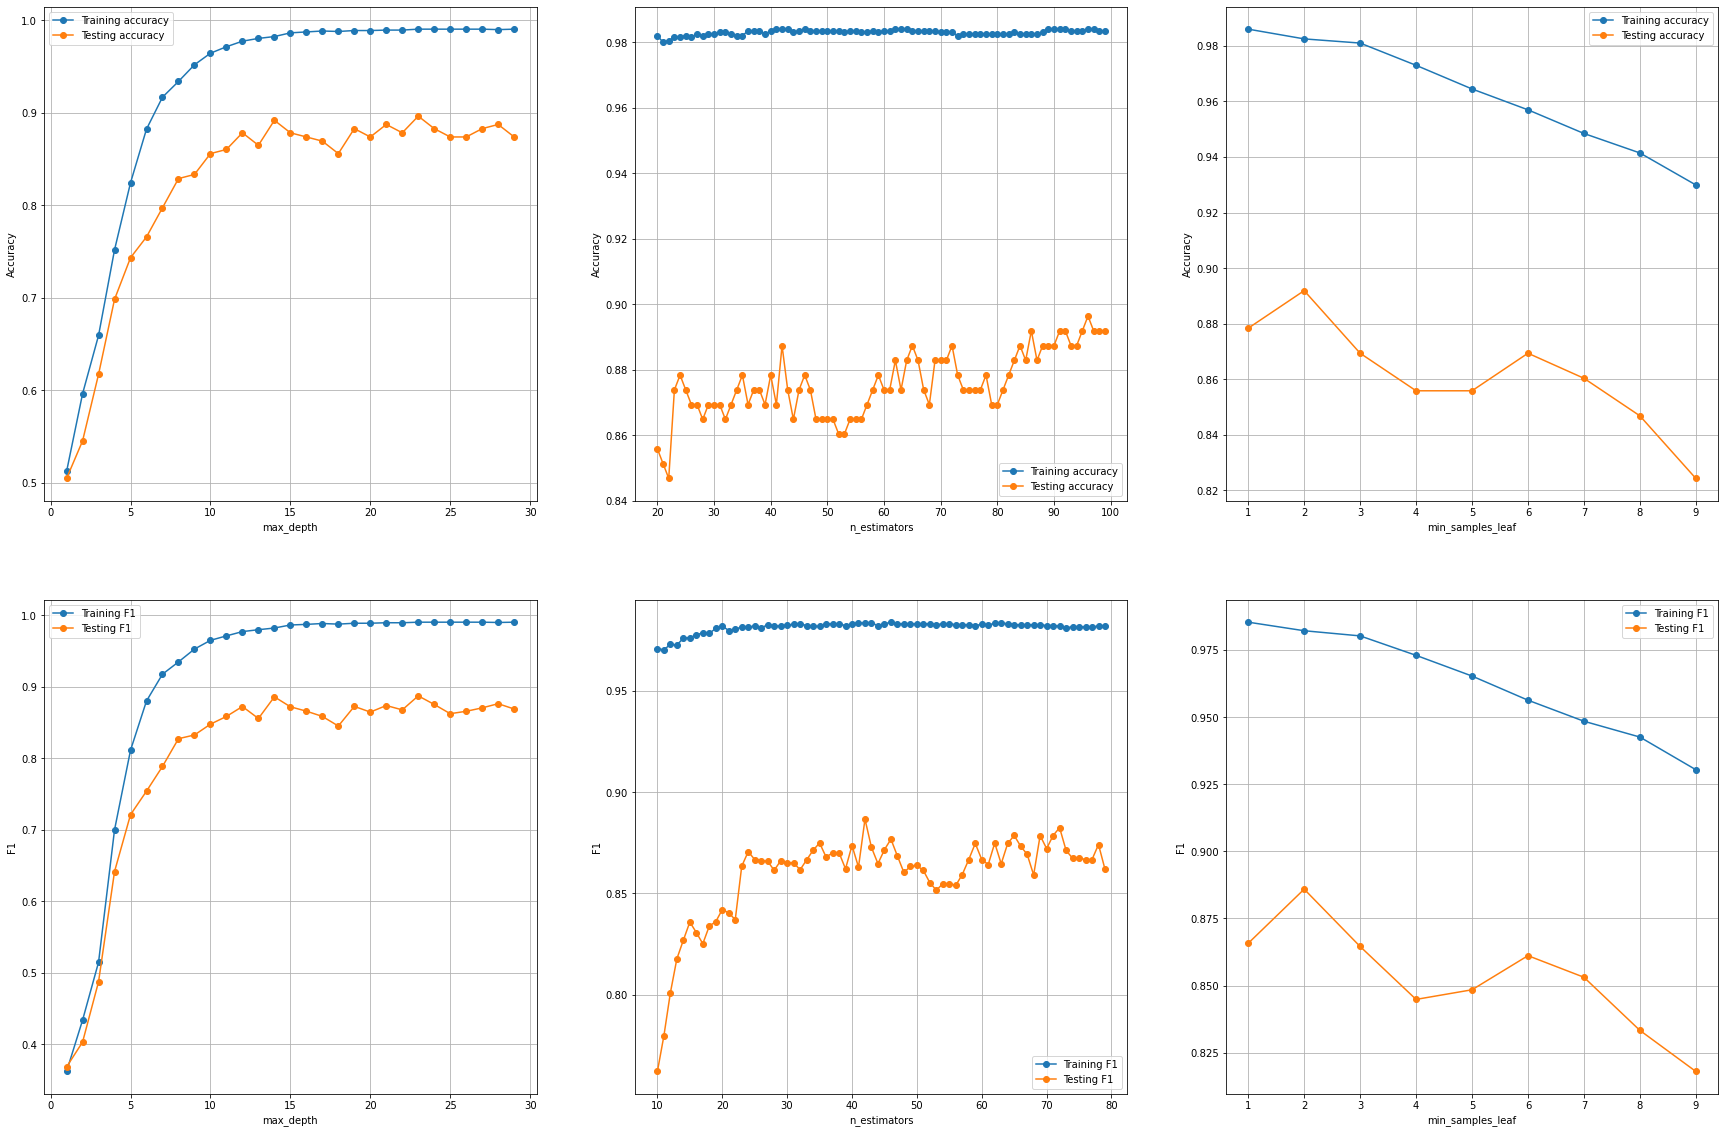

In [130]:
fig, axs = plt.subplots(2,3,figsize=(30,20))
acc_train = []
acc_test = []
for depth in range(1, 30):
    clf = RandomForestClassifier(max_depth=depth,
                                 min_samples_leaf= 2, 
                                 n_estimators= 86, 
                                 random_state=0).fit(X_train_new, y_train)
    acc_train.append(clf.score(X_train_new, y_train))
    acc_test.append(clf.score(X_test_new, y_test))
    
x_axis = range(1, 30)
axs[0,0].plot(x_axis,acc_train,'o-', label='Training accuracy')
axs[0,0].plot(x_axis,acc_test,'o-', label='Testing accuracy')
axs[0,0].grid()
axs[0,0].legend()
axs[0,0].set(xlabel='max_depth', ylabel='Accuracy')

acc_train = []
acc_test = []
for estim in range(20,100):
    clf = RandomForestClassifier(max_depth=14,
                                 min_samples_leaf= 2, 
                                 n_estimators= estim, 
                                 random_state=0).fit(X_train_new, y_train)
    acc_train.append(clf.score(X_train_new, y_train))
    acc_test.append(clf.score(X_test_new, y_test))
    
x_axis = range(20,100)
axs[0,1].plot(x_axis,acc_train,'o-', label='Training accuracy')
axs[0,1].plot(x_axis,acc_test,'o-', label='Testing accuracy')
axs[0,1].grid()
axs[0,1].legend()
axs[0,1].set(xlabel='n_estimators', ylabel='Accuracy')

acc_train = []
acc_test = []
for leaf in range(1, 10):
    clf = RandomForestClassifier(max_depth=14,
                                 min_samples_leaf= leaf, 
                                 n_estimators= 86, 
                                 random_state=0).fit(X_train_new, y_train)
    acc_train.append(clf.score(X_train_new, y_train))
    acc_test.append(clf.score(X_test_new, y_test))
    
x_axis = range(1,10)
axs[0,2].plot(x_axis,acc_train,'o-', label='Training accuracy')
axs[0,2].plot(x_axis,acc_test,'o-', label='Testing accuracy')
axs[0,2].grid()
axs[0,2].legend()
axs[0,2].set(xlabel='min_samples_leaf', ylabel='Accuracy')

f1_train = []
f1_test = []
for depth in range(1, 30):
    clf = RandomForestClassifier(max_depth=depth,
                                 min_samples_leaf= 2, 
                                 n_estimators= 86, 
                                 random_state=0).fit(X_train_new, y_train)
    f1_train.append(f1_score(y_train, clf.predict(X_train_new), average='macro'))
    f1_test.append(f1_score(y_test, clf.predict(X_test_new), average='macro'))

x_axis = range(1, 30)
axs[1,0].plot(x_axis,f1_train,'o-', label='Training F1')
axs[1,0].plot(x_axis,f1_test,'o-', label='Testing F1')
axs[1,0].grid()
axs[1,0].legend()
axs[1,0].set(xlabel='max_depth', ylabel='F1')

f1_train = []
f1_test = []
for estim in range(10,80):
    clf = RandomForestClassifier(max_depth=14,
                                 min_samples_leaf= 2, 
                                 n_estimators= estim, 
                                 random_state=0).fit(X_train_new, y_train)
    f1_train.append(f1_score(y_train, clf.predict(X_train_new), average='macro'))
    f1_test.append(f1_score(y_test, clf.predict(X_test_new), average='macro'))
    
x_axis = range(10,80)
axs[1,1].plot(x_axis,f1_train,'o-', label='Training F1')
axs[1,1].plot(x_axis,f1_test,'o-', label='Testing F1')
axs[1,1].grid()
axs[1,1].legend()
axs[1,1].set(xlabel='n_estimators', ylabel='F1')

f1_train = []
f1_test = []
for leaf in range(1, 10):
    clf = RandomForestClassifier(max_depth=14,
                                 min_samples_leaf= leaf, 
                                 n_estimators= 86, 
                                 random_state=0).fit(X_train_new, y_train)
    f1_train.append(f1_score(y_train, clf.predict(X_train_new), average='macro'))
    f1_test.append(f1_score(y_test, clf.predict(X_test_new), average='macro'))
    
x_axis = range(1,10)
axs[1,2].plot(x_axis,f1_train,'o-', label='Training F1')
axs[1,2].plot(x_axis,f1_test,'o-', label='Testing F1')
axs[1,2].grid()
axs[1,2].legend()
axs[1,2].set(xlabel='min_samples_leaf', ylabel='F1')

# Confusion matrix

In [131]:
#KNN pipe
knn_pipe = Pipeline(steps=[('skb', SelectKBest(f_classif,k=50)),
                               ('scaling',None),
                              ('pca', PCA(n_components=39)), 
                              ('knn', KNeighborsClassifier(n_neighbors=10))])
knn_pipe.fit(X_train, y_train)
print('Train accuracy : %.3f'%knn_pipe.score(X_train, y_train))
print('Test accuracy : %.3f'%knn_pipe.score(X_test, y_test))
print("F1: {:.3f}".format(f1_score(y_train, knn_pipe.predict(X_train), average='macro')))
print("F1: {:.3f}".format(f1_score(y_test, knn_pipe.predict(X_test), average='macro')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_train, knn_pipe.predict_proba(X_train), multi_class='ovr')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, knn_pipe.predict_proba(X_test), multi_class='ovr')))

Train accuracy : 0.888
Test accuracy : 0.838
F1: 0.883
F1: 0.822
ROC AUC: 0.994
ROC AUC: 0.976


Accuracy: 0.838
F1: 0.826


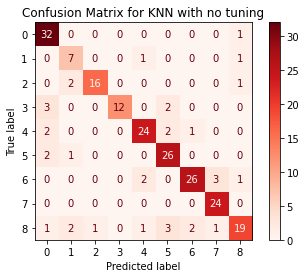

In [132]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
knn= KNeighborsClassifier().fit(X_train, y_train)
pred= knn.predict(X_test)
disp = plot_confusion_matrix(knn, X_test, y_test,
                                 cmap=plt.cm.Reds)
print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))
print("F1: {:.3f}".format(f1_score(y_test, pred, average='macro')))
plt.title("Confusion Matrix for KNN with no tuning")
plt.show()

Accuracy: 0.838
F1: 0.822


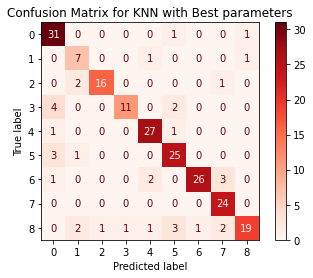

In [133]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
pred= knn_pipe.predict(X_test)
disp = plot_confusion_matrix(knn_pipe, X_test, y_test,
                                 cmap=plt.cm.Reds)
print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))
print("F1: {:.3f}".format(f1_score(y_test, pred, average='macro')))
plt.title("Confusion Matrix for KNN with Best parameters")
plt.show()

In [134]:
#SVC pipe
svc_pipe = Pipeline(steps=[('skb', SelectKBest(f_classif,k=50)),
                           ('scaling',MinMaxScaler()),
                           ('pca', PCA(n_components=49)), 
                               ('svc', SVC(random_state=0,
                                           probability=True, 
                                           C=0.6, 
                                           gamma=1.0))])
svc_pipe.fit(X_train, y_train)
print('Train accuracy : %.3f'%svc_pipe.score(X_train, y_train))
print('Test accuracy : %.3f'%svc_pipe.score(X_test, y_test))
print("F1: {:.3f}".format(f1_score(y_train, svc_pipe.predict(X_train), average='macro')))
print("F1: {:.3f}".format(f1_score(y_test, svc_pipe.predict(X_test), average='macro')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_train, svc_pipe.predict_proba(X_train), multi_class='ovr')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, svc_pipe.predict_proba(X_test), multi_class='ovr')))

Train accuracy : 0.953
Test accuracy : 0.932
F1: 0.953
F1: 0.934
ROC AUC: 0.999
ROC AUC: 0.996


Accuracy: 0.914
F1: 0.914


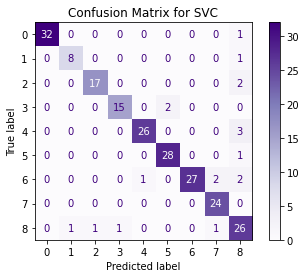

In [135]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
svc= SVC(random_state=0).fit(X_train, y_train)
pred= svc.predict(X_test)
disp = plot_confusion_matrix(svc, X_test, y_test,
                                 cmap=plt.cm.Purples)
print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))
print("F1: {:.3f}".format(f1_score(y_test, pred, average='macro')))
plt.title("Confusion Matrix for SVC")
plt.show()

Accuracy: 0.932
F1: 0.934


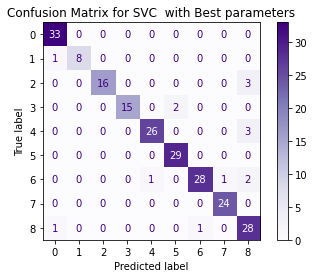

In [136]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
pred= svc_pipe.predict(X_test)
disp = plot_confusion_matrix(svc_pipe, X_test, y_test,
                                 cmap=plt.cm.Purples)
print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))
print("F1: {:.3f}".format(f1_score(y_test, pred, average='macro')))
plt.title("Confusion Matrix for SVC  with Best parameters")
plt.show()

In [137]:
#mlp pipe
mlp_pipe = Pipeline(steps=[('scaling',MinMaxScaler()),
                              ('pca', PCA(n_components=49)),  
                              ('mlp', MLPClassifier(random_state=0, alpha=0.01, hidden_layer_sizes=(94,)))])
mlp_pipe.fit(X_train, y_train)
print('Train accuracy : %.3f'%mlp_pipe.score(X_train, y_train))
print('Test accuracy : %.3f'%mlp_pipe.score(X_test, y_test))
print("F1: {:.3f}".format(f1_score(y_train, mlp_pipe.predict(X_train), average='macro')))
print("F1: {:.3f}".format(f1_score(y_test, mlp_pipe.predict(X_test), average='macro')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_train, mlp_pipe.predict_proba(X_train), multi_class='ovr')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, mlp_pipe.predict_proba(X_test), multi_class='ovr')))

Train accuracy : 0.982
Test accuracy : 0.950
F1: 0.980
F1: 0.945
ROC AUC: 1.000
ROC AUC: 0.997


Accuracy: 0.937
F1: 0.928


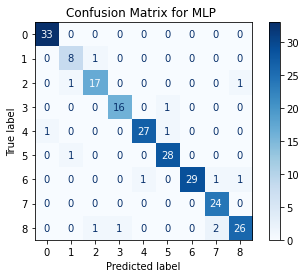

In [138]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
mlp= MLPClassifier(random_state=0).fit(X_train, y_train)
pred= mlp.predict(X_test)
disp = plot_confusion_matrix(mlp, X_test, y_test,
                                 cmap=plt.cm.Blues)
print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))
print("F1: {:.3f}".format(f1_score(y_test, pred, average='macro')))
plt.title("Confusion Matrix for MLP ")
plt.show()

Accuracy: 0.950
F1: 0.945


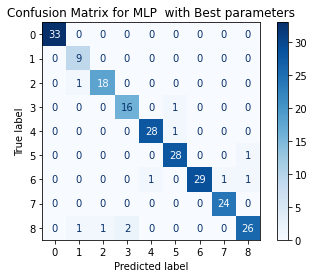

In [139]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
pred= mlp_pipe.predict(X_test)
disp = plot_confusion_matrix(mlp_pipe, X_test, y_test,
                                 cmap=plt.cm.Blues)
print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))
print("F1: {:.3f}".format(f1_score(y_test, pred, average='macro')))
plt.title("Confusion Matrix for MLP  with Best parameters")
plt.show()

In [140]:
#rf pipe
rf_pipe = Pipeline(steps=[('skb', SelectKBest(f_classif,k=50)),
                               ('scaling',None), 
                              ('clf', RandomForestClassifier(random_state=0, 
                                                             n_estimators=86, 
                                                             max_depth=14, 
                                                             min_samples_leaf=2))])
rf_pipe.fit(X_train, y_train)
print('Train accuracy : %.3f'%rf_pipe.score(X_train, y_train))
print('Test accuracy : %.3f'%rf_pipe.score(X_test, y_test))
print("F1: {:.3f}".format(f1_score(y_train, rf_pipe.predict(X_train), average='macro')))
print("F1: {:.3f}".format(f1_score(y_test, rf_pipe.predict(X_test), average='macro')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_train, rf_pipe.predict_proba(X_train), multi_class='ovr')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, rf_pipe.predict_proba(X_test), multi_class='ovr')))

Train accuracy : 0.982
Test accuracy : 0.892
F1: 0.982
F1: 0.886
ROC AUC: 1.000
ROC AUC: 0.985


Accuracy: 0.874
F1: 0.864


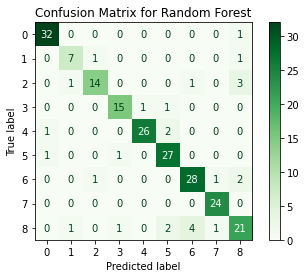

In [141]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
rf= RandomForestClassifier(random_state=0).fit(X_train, y_train)
pred= rf.predict(X_test)
disp = plot_confusion_matrix(rf, X_test, y_test,
                                 cmap=plt.cm.Greens)
print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))
print("F1: {:.3f}".format(f1_score(y_test, pred, average='macro')))
plt.title("Confusion Matrix for Random Forest")
plt.show()

Accuracy: 0.892
F1: 0.886


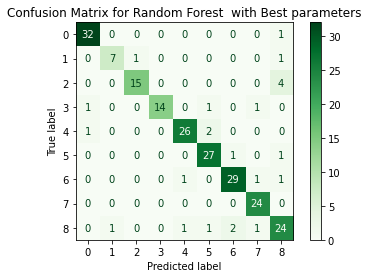

In [142]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
pred= rf_pipe.predict(X_test)
disp = plot_confusion_matrix(rf_pipe, X_test, y_test,
                                 cmap=plt.cm.Greens)
print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))
print("F1: {:.3f}".format(f1_score(y_test, pred, average='macro')))
plt.title("Confusion Matrix for Random Forest  with Best parameters")
plt.show()

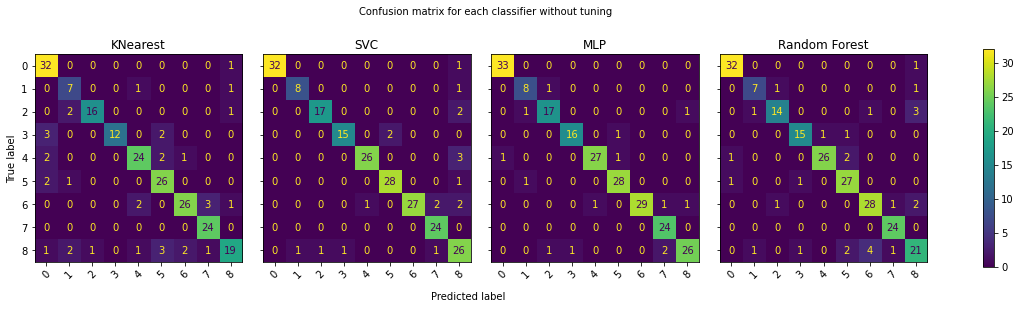

In [143]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
classifiers = {
    "KNearest": KNeighborsClassifier(),
    "SVC":SVC(random_state=0),
    "MLP":MLPClassifier(random_state=0),
    "Random Forest":RandomForestClassifier(random_state=0)

}


f, axes = plt.subplots(1, 4, figsize=(20, 4), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.35, 1, 'Confusion matrix for each classifier without tuning')
f.text(0.4, 0.01, 'Predicted label')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()


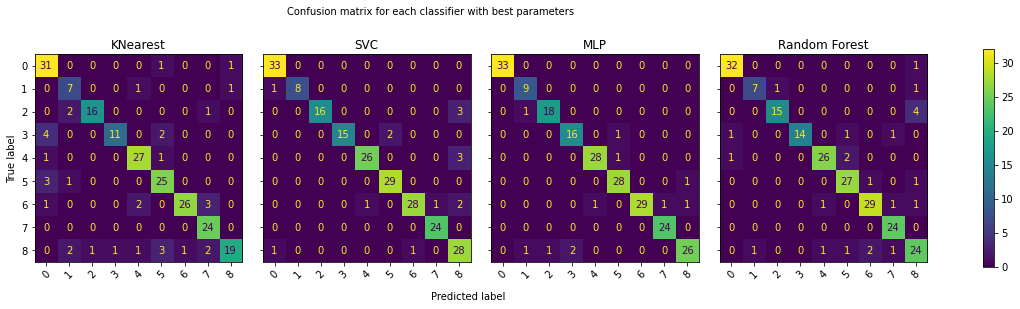

In [144]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
classifiers = {
    "KNearest": knn_pipe,
    "SVC":svc_pipe,
    "MLP":mlp_pipe,
    "Random Forest":rf_pipe

}


f, axes = plt.subplots(1, 4, figsize=(20, 4), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')
        
f.text(0.3, 1, 'Confusion matrix for each classifier with best parameters')
f.text(0.4, 0.01, 'Predicted label')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
f.colorbar(disp.im_, ax=axes)

plt.show()

# Misclassification analysis

In [145]:
knn_pred=knn_pipe.predict(X_test)
index = 0
misclassifiedIndexes_knn = []
for label, predict in zip(knn_pred, y_test):
    if label != predict: 
        misclassifiedIndexes_knn.append(index)
    index +=1

In [146]:
pd.DataFrame({'index':misclassifiedIndexes_knn, 
             'knn predicted': knn_pred[misclassifiedIndexes_knn], 
             'true':y_test[misclassifiedIndexes_knn]})

index  knn predicted  true
0      10              2     8
1      11              5     4
2      17              7     6
3      18              4     6
4      22              0     3
5      23              7     8
6      24              7     6
7      31              7     2
8      41              1     8
9      52              8     0
10     63              5     8
11     65              0     5
12     70              4     8
13     74              6     8
14     78              0     6
15     85              1     8
16     96              0     3
17    110              8     1
18    113              4     6
19    114              0     3
20    115              0     4
21    120              1     5
22    126              5     8
23    127              5     3
24    130              7     8
25    135              5     0
26    150              3     8
27    163              0     5
28    171              4     1
29    178              0     5
30    183              1     2
31    186              0     3
32    194              7     6
33    201              5     3
34    206              1     2
35    217              5     8

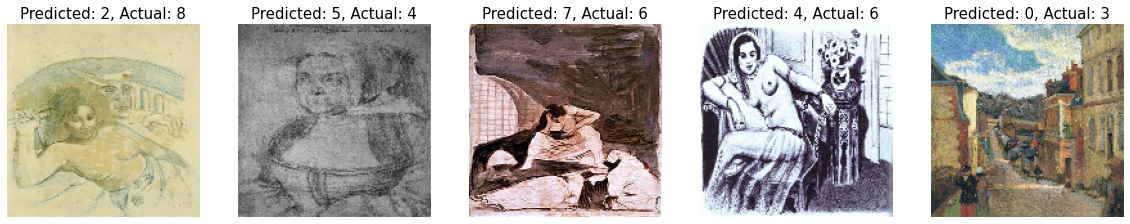

In [147]:
plt.figure(figsize=(20,4))
for plotIndex, badIndex in enumerate(misclassifiedIndexes_knn[0:5]):
    plt.subplot(1,5, plotIndex + 1)
    plt.imshow(img_test[badIndex].reshape(150,150,3))
    plt.axis('off')
    plt.title('Predicted: {}, Actual: {}'.format(knn_pred[badIndex], y_test[badIndex]), fontsize = 15)

In [148]:
svc_pred=svc_pipe.predict(X_test)
index = 0
misclassifiedIndexes_svc = []
for label, predict in zip(svc_pred, y_test):
    if label != predict: 
        misclassifiedIndexes_svc.append(index)
    index +=1

In [149]:
pd.DataFrame({'index':misclassifiedIndexes_svc, 
             'svc predicted': svc_pred[misclassifiedIndexes_svc], 
             'true':y_test[misclassifiedIndexes_svc]})

index  svc predicted  true
0      11              8     4
1      12              8     4
2      18              4     6
3      22              5     3
4      24              7     6
5      31              8     2
6      55              8     4
7     113              8     6
8     117              8     2
9     127              5     3
10    130              6     8
11    150              0     8
12    169              8     2
13    171              0     1
14    221              8     6

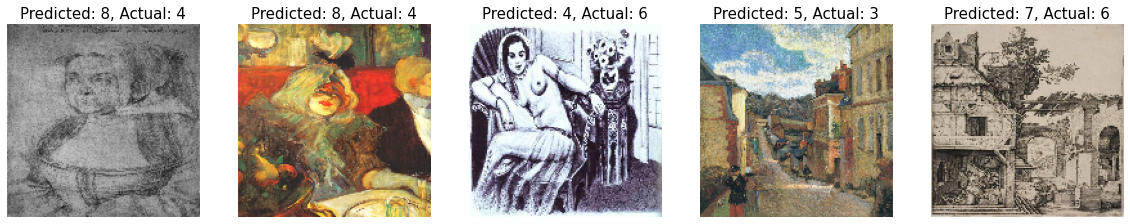

In [150]:
plt.figure(figsize=(20,4))
for plotIndex, badIndex in enumerate(misclassifiedIndexes_svc[0:5]):
    plt.subplot(1,5, plotIndex + 1)
    plt.imshow(img_test[badIndex].reshape(150,150,3))
    plt.axis('off')
    plt.title('Predicted: {}, Actual: {}'.format(svc_pred[badIndex], y_test[badIndex]), fontsize = 15)

In [151]:
mlp_pred=mlp_pipe.predict(X_test)
index = 0
misclassifiedIndexes_mlp = []
for label, predict in zip(mlp_pred, y_test):
    if label != predict: 
        misclassifiedIndexes_mlp.append(index)
    index +=1

In [152]:
pd.DataFrame({'index':misclassifiedIndexes_mlp, 
             'mlp predicted': mlp_pred[misclassifiedIndexes_mlp], 
             'true':y_test[misclassifiedIndexes_mlp]})

index  mlp predicted  true
0      10              2     8
1      11              5     4
2      18              4     6
3      24              7     6
4      31              1     2
5      38              3     8
6      41              1     8
7     113              8     6
8     127              5     3
9     150              3     8
10    178              8     5

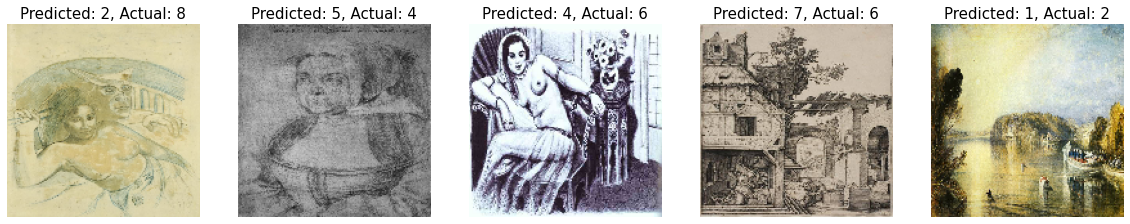

In [153]:
plt.figure(figsize=(20,4))
for plotIndex, badIndex in enumerate(misclassifiedIndexes_mlp[0:5]):
    plt.subplot(1,5, plotIndex + 1)
    plt.imshow(img_test[badIndex].reshape(150,150,3))
    plt.axis('off')
    plt.title('Predicted: {}, Actual: {}'.format(mlp_pred[badIndex], y_test[badIndex]), fontsize = 15)

In [154]:
rf_pred=rf_pipe.predict(X_test)
index = 0
misclassifiedIndexes_rf = []
for label, predict in zip(rf_pred, y_test):
    if label != predict: 
        misclassifiedIndexes_rf.append(index)
    index +=1

In [155]:
pd.DataFrame({'index':misclassifiedIndexes_rf, 
             'rf predicted': rf_pred[misclassifiedIndexes_rf], 
             'true':y_test[misclassifiedIndexes_rf]})

index  rf predicted  true
0      11             5     4
1      18             4     6
2      21             4     8
3      23             7     8
4      24             7     6
5      31             8     2
6      32             5     4
7      41             1     8
8      52             8     0
9      74             6     8
10     85             6     8
11     94             6     5
12     96             0     3
13    109             7     3
14    110             8     1
15    113             8     6
16    117             8     2
17    120             8     5
18    127             5     3
19    138             8     2
20    171             2     1
21    183             8     2
22    192             0     4
23    217             5     8

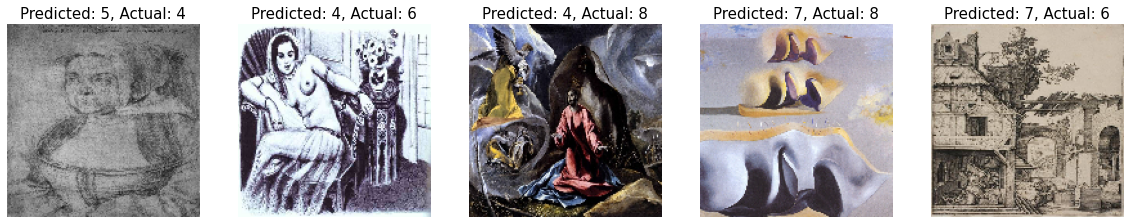

In [156]:
plt.figure(figsize=(20,4))
for plotIndex, badIndex in enumerate(misclassifiedIndexes_rf[0:5]):
    plt.subplot(1,5, plotIndex + 1)
    plt.imshow(img_test[badIndex].reshape(150,150,3))
    plt.axis('off')
    plt.title('Predicted: {}, Actual: {}'.format(rf_pred[badIndex], y_test[badIndex]), fontsize = 15)

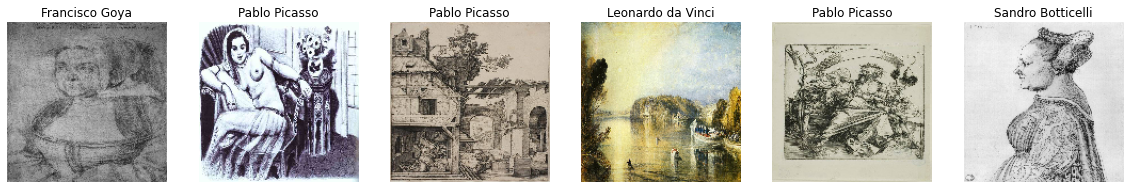

In [157]:
labels=['Pierre-Auguste Renoir', 
        'Raphael', 
        'Leonardo da Vinci', 
        'Sandro Botticelli', 
        'Francisco Goya', 
        'Vincent van Gogh', 
        'Pablo Picasso', 
        'Albrecht Durer', 
        'Others']
# paintings misclassified by all four classifiers
plt.figure(figsize=(20,4))
for plotIndex, badIndex in enumerate([11,18,24,31,113,127]):
    plt.subplot(1,6, plotIndex + 1)
    plt.imshow(img_test[badIndex].reshape(150,150,3))
    plt.axis('off')
    plt.title(labels[y_test[badIndex]])


In [158]:
miss=[11,18,24,31,113,127]
pd.DataFrame({'index':miss, 
             'knn predicted': knn_pred[miss], 
              'svc predicted': svc_pred[miss], 
              'mlp predicted': mlp_pred[miss], 
              'rf predicted': rf_pred[miss], 
             'true':y_test[miss]})

index  knn predicted  svc predicted  mlp predicted  rf predicted  true
0     11              5              8              5             5     4
1     18              4              4              4             4     6
2     24              7              7              7             7     6
3     31              7              8              1             8     2
4    113              4              8              8             8     6
5    127              5              5              5             5     3

# Ensemble Methods

## Bagging

In [159]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

## KNN Bagging

In [160]:
#For the base classifier, we use knn_pipe
bag = BaggingClassifier(base_estimator=knn_pipe,
                        n_estimators=50, 
                        max_samples=0.75, #draw % of the number of samples (with replacement) for each
                        bootstrap=True, #sampling with replacement after each
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=0)
#knn pipe scores
print('Train accuracy : %.3f'%knn_pipe.score(X_train, y_train))
print('Test accuracy : %.3f'%knn_pipe.score(X_test, y_test))
print("F1: {:.3f}".format(f1_score(y_train, knn_pipe.predict(X_train), average='macro')))
print("F1: {:.3f}".format(f1_score(y_test, knn_pipe.predict(X_test), average='macro')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_train, knn_pipe.predict_proba(X_train), multi_class='ovr')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, knn_pipe.predict_proba(X_test), multi_class='ovr')))

#parameters for gridsearch
params_bag = [{'n_estimators': [10, 50, 100],
                 'max_samples': [0.75, 1.0]}]
#gridsearch for bagging
gs_bag = GridSearchCV(estimator=bag,
                          param_grid=params_bag,
                          scoring='accuracy',
                          cv=4)
gs_bag.fit(X_train, y_train)
#bagging scores
print('Train accuracy : %.3f'%gs_bag.score(X_train, y_train))
print('Test accuracy : %.3f'%gs_bag.score(X_test, y_test))
print("F1: {:.3f}".format(f1_score(y_train, gs_bag.predict(X_train), average='macro')))
print("F1: {:.3f}".format(f1_score(y_test, gs_bag.predict(X_test), average='macro')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_train, gs_bag.predict_proba(X_train), multi_class='ovr')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, gs_bag.predict_proba(X_test), multi_class='ovr')))
print('Best Parameters : ',gs_bag.best_params_)
#print('All results : ',pd.DataFrame(gs_bag.cv_results_))

Train accuracy : 0.888
Test accuracy : 0.838
F1: 0.883
F1: 0.822
ROC AUC: 0.994
ROC AUC: 0.976
Train accuracy : 0.894
Test accuracy : 0.829
F1: 0.890
F1: 0.813
ROC AUC: 0.995
ROC AUC: 0.983
Best Parameters :  {'max_samples': 1.0, 'n_estimators': 100}


In [161]:
#knn classifier
knn=KNeighborsClassifier()
knn.fit(X_train, y_train)
#bagging scores
print('Train accuracy : %.3f'%knn.score(X_train, y_train))
print('Test accuracy : %.3f'%knn.score(X_test, y_test))
print("F1: {:.3f}".format(f1_score(y_train, knn.predict(X_train), average='macro')))
print("F1: {:.3f}".format(f1_score(y_test, knn.predict(X_test), average='macro')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_train, knn.predict_proba(X_train), multi_class='ovr')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, knn.predict_proba(X_test), multi_class='ovr')))
#bagging classifier with knn as base estimator
bag = BaggingClassifier(base_estimator=knn,
                        n_estimators=50, 
                        max_samples=0.75, #draw % of the number of samples (with replacement) for each
                        bootstrap=True, #sampling with replacement after each
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=0)
#parameters for gridsearch
params_bag = [{'n_estimators': [10, 50],
                 'max_samples': [0.75, 1.0]}]
#gridsearch for bagging
gs_bag_best = GridSearchCV(estimator=bag,
                          param_grid=params_bag,
                          scoring='accuracy',
                          cv=4)
gs_bag_best.fit(X_train, y_train)
#bagging scores
print('Train accuracy : %.3f'%gs_bag_best.score(X_train, y_train))
print('Test accuracy : %.3f'%gs_bag_best.score(X_test, y_test))
print("F1: {:.3f}".format(f1_score(y_train, gs_bag_best.predict(X_train), average='macro')))
print("F1: {:.3f}".format(f1_score(y_test, gs_bag_best.predict(X_test), average='macro')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_train, gs_bag_best.predict_proba(X_train), multi_class='ovr')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, gs_bag_best.predict_proba(X_test), multi_class='ovr')))
print('Best Parameters : ',gs_bag_best.best_params_)
#print('All results : ',pd.DataFrame(gs_bag_best.cv_results_))

Train accuracy : 0.911
Test accuracy : 0.838
F1: 0.905
F1: 0.826
ROC AUC: 0.996
ROC AUC: 0.970
Train accuracy : 0.927
Test accuracy : 0.851
F1: 0.924
F1: 0.835
ROC AUC: 0.998
ROC AUC: 0.981
Best Parameters :  {'max_samples': 1.0, 'n_estimators': 50}


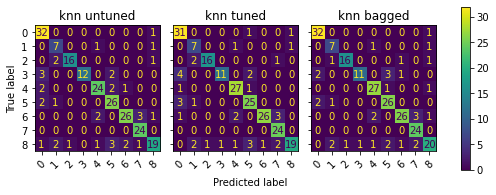

In [162]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
classifiers = {
    "knn untuned": knn,
    "knn tuned": knn_pipe,
    "knn bagged":gs_bag_best.best_estimator_,

}


f, axes = plt.subplots(1, 3, figsize=(9,3), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.05, 'Predicted label')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [163]:
bag_pred=gs_bag.predict(X_test)
index = 0
misclassifiedIndexes_bag = []
for label, predict in zip(bag_pred, y_test):
    if label != predict: 
        misclassifiedIndexes_bag.append(index)
    index +=1

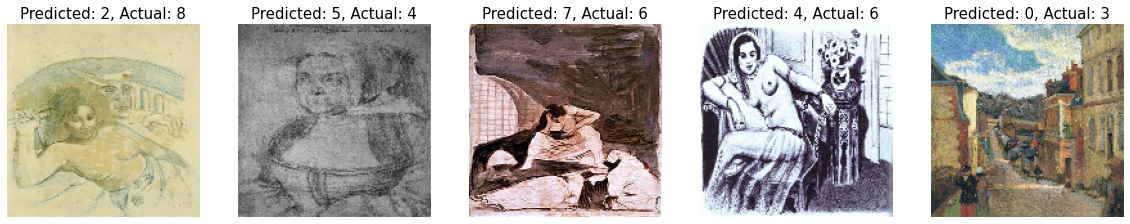

In [164]:
plt.figure(figsize=(20,4))
for plotIndex, badIndex in enumerate(misclassifiedIndexes_bag[0:5]):
    plt.subplot(1,5, plotIndex + 1)
    plt.imshow(img_test[badIndex].reshape(150,150,3))
    plt.axis('off')
    plt.title('Predicted: {}, Actual: {}'.format(bag_pred[badIndex], y_test[badIndex]), fontsize = 15)

## SVC Bagging

In [165]:
#For the base classifier, we use svc_pipe
bag = BaggingClassifier(base_estimator=svc_pipe,
                        n_estimators=500, 
                        max_samples=1.0, #draw 100% of the number of samples (with replacement) for each
                        bootstrap=True, #sampling with replacement after each
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=0)
#bag.get_params()
#svc pipe scores
print('Train accuracy : %.3f'%svc_pipe.score(X_train, y_train))
print('Test accuracy : %.3f'%svc_pipe.score(X_test, y_test))
print("F1: {:.3f}".format(f1_score(y_train, svc_pipe.predict(X_train), average='macro')))
print("F1: {:.3f}".format(f1_score(y_test, svc_pipe.predict(X_test), average='macro')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_train, svc_pipe.predict_proba(X_train), multi_class='ovr')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, svc_pipe.predict_proba(X_test), multi_class='ovr')))

#parameters for gridsearch
params_bag = [{'n_estimators': [10, 50, 100],
                 'max_samples': [0.75, 1.0]}]
#gridsearch for bagging
gs_bag_best = GridSearchCV(estimator=bag,
                          param_grid=params_bag,
                          scoring='accuracy',
                          cv=4)
gs_bag_best.fit(X_train, y_train)
#bagging scores
print('Train accuracy : %.3f'%gs_bag_best.score(X_train, y_train))
print('Test accuracy : %.3f'%gs_bag_best.score(X_test, y_test))
print("F1: {:.3f}".format(f1_score(y_train, gs_bag_best.predict(X_train), average='macro')))
print("F1: {:.3f}".format(f1_score(y_test, gs_bag_best.predict(X_test), average='macro')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_train, gs_bag_best.predict_proba(X_train), multi_class='ovr')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, gs_bag_best.predict_proba(X_test), multi_class='ovr')))
print('Best Parameters : ',gs_bag_best.best_params_)
#print('All results : ',pd.DataFrame(gs_bag_best.cv_results_))

Train accuracy : 0.953
Test accuracy : 0.932
F1: 0.953
F1: 0.934
ROC AUC: 0.999
ROC AUC: 0.996
Train accuracy : 0.966
Test accuracy : 0.923
F1: 0.966
F1: 0.918
ROC AUC: 0.999
ROC AUC: 0.995
Best Parameters :  {'max_samples': 1.0, 'n_estimators': 50}


In [166]:
#svc classifier
svc=SVC(random_state=0,probability=True)
svc.fit(X_train, y_train)
#svc scores
print('Train accuracy : %.3f'%svc.score(X_train, y_train))
print('Test accuracy : %.3f'%svc.score(X_test, y_test))
print("F1: {:.3f}".format(f1_score(y_train, svc.predict(X_train), average='macro')))
print("F1: {:.3f}".format(f1_score(y_test, svc.predict(X_test), average='macro')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_train, svc.predict_proba(X_train), multi_class='ovr')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, svc.predict_proba(X_test), multi_class='ovr')))
#bagging classifier with svc as base estimator
bag = BaggingClassifier(base_estimator=svc,
                        n_estimators=50, 
                        max_samples=0.75, #draw % of the number of samples (with replacement) for each
                        bootstrap=True, #sampling with replacement after each
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=0)
#parameters for gridsearch
params_bag = [{'n_estimators': [10, 50, 100],
                 'max_samples': [0.75, 1.0]}]
#gridsearch for bagging
gs_bag = GridSearchCV(estimator=bag,
                          param_grid=params_bag,
                          scoring='accuracy',
                          cv=4)
gs_bag.fit(X_train, y_train)
#bagging scores
print('Train accuracy : %.3f'%gs_bag.score(X_train, y_train))
print('Test accuracy : %.3f'%gs_bag.score(X_test, y_test))
print("F1: {:.3f}".format(f1_score(y_train, gs_bag.predict(X_train), average='macro')))
print("F1: {:.3f}".format(f1_score(y_test, gs_bag.predict(X_test), average='macro')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_train, gs_bag.predict_proba(X_train), multi_class='ovr')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, gs_bag.predict_proba(X_test), multi_class='ovr')))
print('Best Parameters : ',gs_bag.best_params_)
#print('All results : ',pd.DataFrame(gs_bag.cv_results_))

Train accuracy : 0.958
Test accuracy : 0.914
F1: 0.958
F1: 0.914
ROC AUC: 0.999
ROC AUC: 0.995
Train accuracy : 0.962
Test accuracy : 0.901
F1: 0.963
F1: 0.894
ROC AUC: 0.999
ROC AUC: 0.995
Best Parameters :  {'max_samples': 1.0, 'n_estimators': 50}


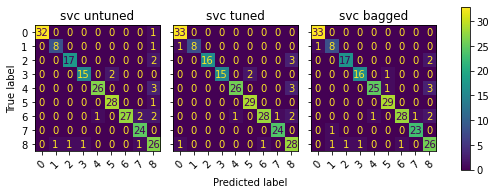

In [167]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
classifiers = {
    "svc untuned": svc,
    "svc tuned": svc_pipe,
    "svc bagged":gs_bag_best.best_estimator_,

}


f, axes = plt.subplots(1, 3, figsize=(9,3), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.05, 'Predicted label')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

## MLP Bagging

In [168]:
#mlp scores
print('Train accuracy : %.3f'%mlp_pipe.score(X_train, y_train))
print('Test accuracy : %.3f'%mlp_pipe.score(X_test, y_test))
print("F1: {:.3f}".format(f1_score(y_train, mlp_pipe.predict(X_train), average='macro')))
print("F1: {:.3f}".format(f1_score(y_test, mlp_pipe.predict(X_test), average='macro')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_train, mlp_pipe.predict_proba(X_train), multi_class='ovr')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, mlp_pipe.predict_proba(X_test), multi_class='ovr')))
#bagging classifier with svc as base estimator
bag = BaggingClassifier(base_estimator=mlp_pipe,
                        n_estimators=50, 
                        max_samples=0.75, #draw % of the number of samples (with replacement) for each
                        bootstrap=True, #sampling with replacement after each
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=0)
#parameters for gridsearch
params_bag = [{'n_estimators': [10, 50, 100],
                 'max_samples': [0.75, 1.0]}]
#gridsearch for bagging
gs_bag_best = GridSearchCV(estimator=bag,
                          param_grid=params_bag,
                          scoring='accuracy',
                          cv=4)
gs_bag_best.fit(X_train, y_train)
#bagging scores
print('Train accuracy : %.3f'%gs_bag_best.score(X_train, y_train))
print('Test accuracy : %.3f'%gs_bag_best.score(X_test, y_test))
print("F1: {:.3f}".format(f1_score(y_train, gs_bag_best.predict(X_train), average='macro')))
print("F1: {:.3f}".format(f1_score(y_test, gs_bag_best.predict(X_test), average='macro')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_train, gs_bag_best.predict_proba(X_train), multi_class='ovr')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, gs_bag_best.predict_proba(X_test), multi_class='ovr')))
print('Best Parameters : ',gs_bag_best.best_params_)
#print('All results : ',pd.DataFrame(gs_bag_best.cv_results_))

Train accuracy : 0.982
Test accuracy : 0.950
F1: 0.980
F1: 0.945
ROC AUC: 1.000
ROC AUC: 0.997
Train accuracy : 0.981
Test accuracy : 0.941
F1: 0.979
F1: 0.935
ROC AUC: 1.000
ROC AUC: 0.997
Best Parameters :  {'max_samples': 1.0, 'n_estimators': 100}


In [169]:
#mlp classifier
mlp=MLPClassifier(random_state=0)
mlp.fit(X_train, y_train)
#mlp scores
print('Train accuracy : %.3f'%mlp.score(X_train, y_train))
print('Test accuracy : %.3f'%mlp.score(X_test, y_test))
print("F1: {:.3f}".format(f1_score(y_train, mlp.predict(X_train), average='macro')))
print("F1: {:.3f}".format(f1_score(y_test, mlp.predict(X_test), average='macro')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_train, mlp.predict_proba(X_train), multi_class='ovr')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, mlp.predict_proba(X_test), multi_class='ovr')))
#bagging classifier with svc as base estimator
bag = BaggingClassifier(base_estimator=mlp,
                        n_estimators=50, 
                        max_samples=0.75, #draw % of the number of samples (with replacement) for each
                        bootstrap=True, #sampling with replacement after each
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=0)
#parameters for gridsearch
params_bag = [{'n_estimators': [10, 50, 100],
                 'max_samples': [0.75, 1.0]}]
#gridsearch for bagging
gs_bag = GridSearchCV(estimator=bag,
                          param_grid=params_bag,
                          scoring='accuracy',
                          cv=4)
gs_bag.fit(X_train, y_train)
#bagging scores
print('Train accuracy : %.3f'%gs_bag.score(X_train, y_train))
print('Test accuracy : %.3f'%gs_bag.score(X_test, y_test))
print("F1: {:.3f}".format(f1_score(y_train, gs_bag.predict(X_train), average='macro')))
print("F1: {:.3f}".format(f1_score(y_test, gs_bag.predict(X_test), average='macro')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_train, gs_bag.predict_proba(X_train), multi_class='ovr')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, gs_bag.predict_proba(X_test), multi_class='ovr')))
print('Best Parameters : ',gs_bag.best_params_)
#print('All results : ',pd.DataFrame(gs_bag.cv_results_))

Train accuracy : 0.992
Test accuracy : 0.937
F1: 0.992
F1: 0.928
ROC AUC: 1.000
ROC AUC: 0.996
Train accuracy : 0.992
Test accuracy : 0.932
F1: 0.992
F1: 0.917
ROC AUC: 1.000
ROC AUC: 0.996
Best Parameters :  {'max_samples': 1.0, 'n_estimators': 50}


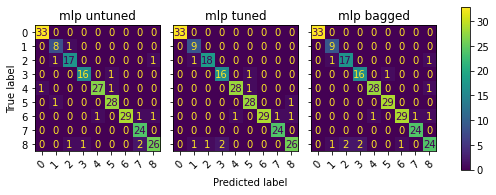

In [170]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
classifiers = {
    "mlp untuned": mlp,
    "mlp tuned": mlp_pipe,
    "mlp bagged":gs_bag_best.best_estimator_,

}


f, axes = plt.subplots(1, 3, figsize=(9,3), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.05, 'Predicted label')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [171]:
bag_pred=gs_bag.predict(X_test)
index = 0
misclassifiedIndexes_bag = []
for label, predict in zip(bag_pred, y_test):
    if label != predict: 
        misclassifiedIndexes_bag.append(index)
    index +=1

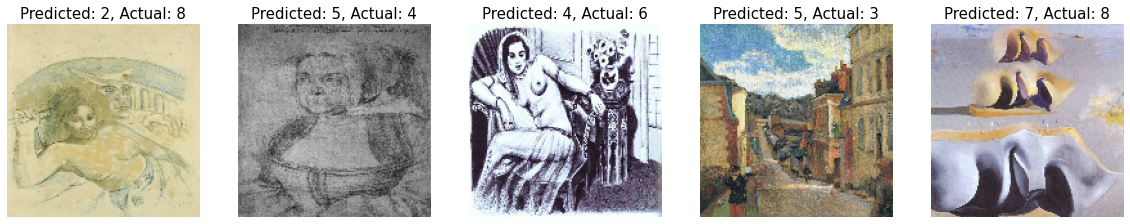

In [172]:
plt.figure(figsize=(20,4))
for plotIndex, badIndex in enumerate(misclassifiedIndexes_bag[0:5]):
    plt.subplot(1,5, plotIndex + 1)
    plt.imshow(img_test[badIndex].reshape(150,150,3))
    plt.axis('off')
    plt.title('Predicted: {}, Actual: {}'.format(bag_pred[badIndex], y_test[badIndex]), fontsize = 15)

## AdaBoost

In [173]:
from sklearn.ensemble import AdaBoostClassifier

## Decision Tree adaboost

In [174]:
#find the best tree
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)
pca = PCA()
tree_pipe = Pipeline(steps=[('skb', SelectKBest(f_classif,)),
                               ('scaling',None),
                              ('pca', pca), 
                              ('clf', tree)])
 
params = [{'skb__k':[50, 64],'pca__n_components': [28, 39], 'clf__min_samples_leaf':[2,3,5]}]
# Feature selection and PCA pipe with RF and accuracy score
 
gs_tree = GridSearchCV(estimator=tree_pipe,
      param_grid=params,
      scoring='accuracy',
      cv=4)
 
gs_tree.fit(X_train, y_train)
print('Train Accuracy : %.3f'%gs_tree.score(X_train, y_train))
print('Test Accuracy : %.3f'%gs_tree.score(X_test, y_test))
print("F1: {:.3f}".format(f1_score(y_train, gs_tree.predict(X_train), average='macro')))
print("F1: {:.3f}".format(f1_score(y_test, gs_tree.predict(X_test), average='macro')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_train, gs_tree.predict_proba(X_train), multi_class='ovr')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, gs_tree.predict_proba(X_test), multi_class='ovr')))
print('Best Parameters : ',gs_tree.best_params_)
#print('All results : ',pd.DataFrame(gs_tree.cv_results_))

Train Accuracy : 0.894
Test Accuracy : 0.586
F1: 0.887
F1: 0.575
ROC AUC: 0.996
ROC AUC: 0.812
Best Parameters :  {'clf__min_samples_leaf': 3, 'pca__n_components': 28, 'skb__k': 50}


In [175]:
#set up the base classifier
tree = DecisionTreeClassifier(random_state=0, min_samples_leaf=3)
# set up the adaboost pipe
ada_pipe = Pipeline(steps=[('scaling',None),
                              ('pca', PCA(n_components=28)), 
                              ('clf', AdaBoostClassifier(base_estimator=tree,
                         n_estimators=10, 
                         learning_rate=1, #shrinks the contribution of each classifier
                         random_state=0))])
#ada.get_params()

In [176]:
#set parameters for gridsearch
params = [{'clf__learning_rate':[1],
            'clf__n_estimators': [30]}]
 
gs_ada = GridSearchCV(estimator=ada_pipe,
      param_grid=params,
      scoring='accuracy',
      cv=4)
gs_ada.fit(X_train, y_train)
print('Train Accuracy : %.3f'%gs_ada.score(X_train, y_train))
print('Test Accuracy : %.3f'%gs_ada.score(X_test, y_test))
print("F1: {:.3f}".format(f1_score(y_train, gs_ada.predict(X_train), average='macro')))
print("F1: {:.3f}".format(f1_score(y_test, gs_ada.predict(X_test), average='macro')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_train, gs_ada.predict_proba(X_train), multi_class='ovr')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test,gs_ada.predict_proba(X_test), multi_class='ovr')))
print('Best Parameters : ',gs_ada.best_params_)
#print('All results : ',pd.DataFrame(gs_ada.cv_results_))

Train Accuracy : 0.992
Test Accuracy : 0.806
F1: 0.992
F1: 0.779
ROC AUC: 1.000
ROC AUC: 0.957
Best Parameters :  {'clf__learning_rate': 1, 'clf__n_estimators': 30}


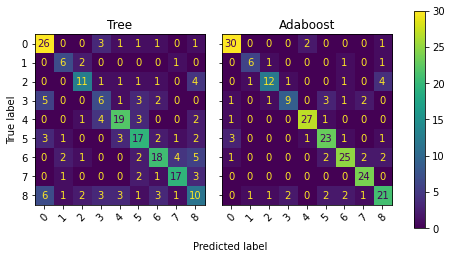

In [177]:
classifiers = {
    "Tree": gs_tree.best_estimator_,
    "Adaboost":gs_ada.best_estimator_,

}


f, axes = plt.subplots(1, 2, figsize=(8,4), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.05, 'Predicted label')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

## SVC adaboost

In [178]:
scaler = MinMaxScaler().fit(X_train)
#scale the data
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)
#fit data kbest=50 and pca=39
kbest = SelectKBest(f_classif,k=50).fit(X_train_s, y_train)
X_train_new=kbest.transform(X_train_s)
X_test_new=kbest.transform(X_test_s)
pca = PCA(n_components=39).fit(X_train_new)
pca.fit(X_train_new)
X_train_new = pca.transform(X_train_new)
X_test_new = pca.transform(X_test_new)

svc= SVC(random_state=0,probability=True,C=0.6, gamma=1.0)
svc.fit(X_train_new, y_train)
print('Train Accuracy : %.3f'%svc.score(X_train_new, y_train))
print('Test Accuracy : %.3f'%svc.score(X_test_new, y_test))
print("F1: {:.3f}".format(f1_score(y_train, svc.predict(X_train_new), average='macro')))
print("F1: {:.3f}".format(f1_score(y_test, svc.predict(X_test_new), average='macro')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_train, svc.predict_proba(X_train_new), multi_class='ovr')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, svc.predict_proba(X_test_new), multi_class='ovr')))

ada_pipe = Pipeline(steps=[('skb', SelectKBest(f_classif,k=50)),
                               ('scaling',MinMaxScaler()),
                              ('pca', PCA(n_components=28)), 
                              ('clf', AdaBoostClassifier(base_estimator=svc,
                         n_estimators=10, 
                         learning_rate=1, #shrinks the contribution of each classifier
                         random_state=0))])
#ada_pipe.get_params()

Train Accuracy : 0.952
Test Accuracy : 0.937
F1: 0.952
F1: 0.933
ROC AUC: 0.999
ROC AUC: 0.996


In [179]:
params = [{'clf__learning_rate':[0.1,1],
            'clf__n_estimators': [5, 10]}]
 
gs_ada = GridSearchCV(estimator=ada_pipe,
      param_grid=params,
      scoring='accuracy',
      cv=4)
gs_ada.fit(X_train, y_train)
print('Train Accuracy : %.3f'%gs_ada.score(X_train, y_train))
print('Test Accuracy : %.3f'%gs_ada.score(X_test, y_test))
print("F1: {:.3f}".format(f1_score(y_train, gs_ada.predict(X_train), average='macro')))
print("F1: {:.3f}".format(f1_score(y_test, gs_ada.predict(X_test), average='macro')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_train, gs_ada.predict_proba(X_train), multi_class='ovr')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, gs_ada.predict_proba(X_test), multi_class='ovr')))
print('Best Parameters : ',gs_ada.best_params_)
#print('All results : ',pd.DataFrame(gs_ada.cv_results_))

Train Accuracy : 0.864
Test Accuracy : 0.847
F1: 0.859
F1: 0.839
ROC AUC: 0.988
ROC AUC: 0.982
Best Parameters :  {'clf__learning_rate': 1, 'clf__n_estimators': 5}


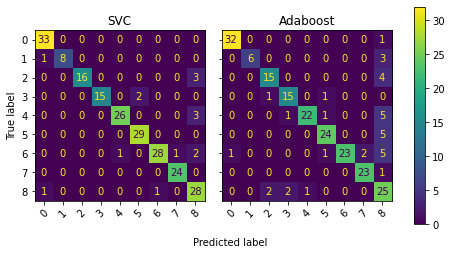

In [180]:
classifiers = {
    "SVC": svc_pipe,
    "Adaboost":gs_ada.best_estimator_,

}


f, axes = plt.subplots(1, 2, figsize=(8,4), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.05, 'Predicted label')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

## random forest adaboost

In [181]:
kbest = SelectKBest(f_classif,k=50).fit(X_train, y_train)
X_train_new=kbest.transform(X_train)
X_test_new=kbest.transform(X_test)
rf= RandomForestClassifier(random_state=0, n_estimators=86,max_depth=14,min_samples_leaf=2)
rf.fit(X_train_new, y_train)
print('Train Accuracy : %.3f'%rf.score(X_train_new, y_train))
print('Test Accuracy : %.3f'%rf.score(X_test_new, y_test))
print("F1: {:.3f}".format(f1_score(y_train, rf.predict(X_train_new), average='macro')))
print("F1: {:.3f}".format(f1_score(y_test, rf.predict(X_test_new), average='macro')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_train, rf.predict_proba(X_train_new), multi_class='ovr')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, rf.predict_proba(X_test_new), multi_class='ovr')))


ada_pipe = Pipeline(steps=[('skb', SelectKBest(f_classif,k=50)),
                              ('clf', AdaBoostClassifier(base_estimator=rf,
                         n_estimators=10, 
                         learning_rate=1, #shrinks the contribution of each classifier
                         random_state=0))])

#ada_pipe.get_params()

Train Accuracy : 0.982
Test Accuracy : 0.892
F1: 0.982
F1: 0.886
ROC AUC: 1.000
ROC AUC: 0.985


In [182]:
params = [{'clf__learning_rate':[0.5],
            'clf__n_estimators': [4]}]
 
gs_ada = GridSearchCV(estimator=ada_pipe,
      param_grid=params,
      scoring='accuracy',
      cv=4)
gs_ada.fit(X_train, y_train)
print('Train Accuracy : %.3f'%gs_ada.score(X_train, y_train))
print('Test Accuracy : %.3f'%gs_ada.score(X_test, y_test))
print("F1: {:.3f}".format(f1_score(y_train, gs_ada.predict(X_train), average='macro')))
print("F1: {:.3f}".format(f1_score(y_test, gs_ada.predict(X_test), average='macro')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_train, gs_ada.predict_proba(X_train), multi_class='ovr')))
print("ROC AUC: {:.3f}".format(roc_auc_score(y_test, gs_ada.predict_proba(X_test), multi_class='ovr')))
print('Best Parameters : ',gs_ada.best_params_)
#print('All results : ',pd.DataFrame(gs_ada.cv_results_))

Train Accuracy : 0.990
Test Accuracy : 0.896
F1: 0.990
F1: 0.885
ROC AUC: 1.000
ROC AUC: 0.983
Best Parameters :  {'clf__learning_rate': 0.5, 'clf__n_estimators': 4}


In [183]:
ada_pred=gs_ada.predict(X_test)
index = 0
misclassifiedIndexes_ada = []
for label, predict in zip(ada_pred, y_test):
    if label != predict: 
        misclassifiedIndexes_ada.append(index)
    index +=1

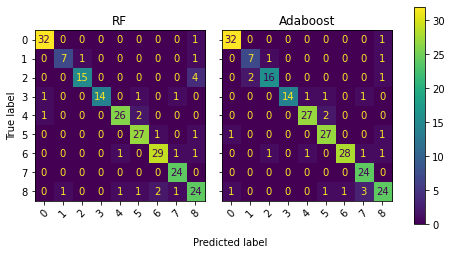

In [184]:
classifiers = {
    "RF": rf_pipe,
    "Adaboost":gs_ada.best_estimator_,

}


f, axes = plt.subplots(1, 2, figsize=(8,4), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.05, 'Predicted label')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

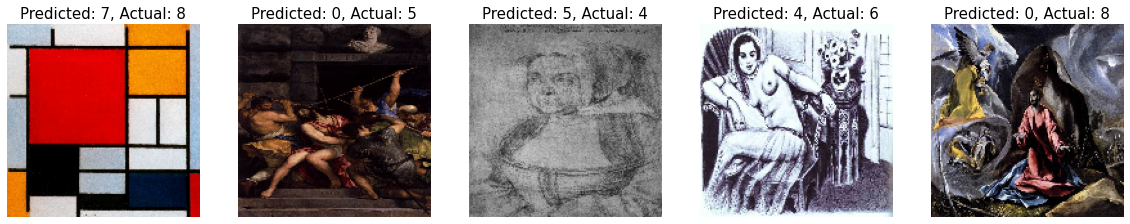

In [185]:
plt.figure(figsize=(20,4))
for plotIndex, badIndex in enumerate(misclassifiedIndexes_ada[0:5]):
    plt.subplot(1,5, plotIndex + 1)
    plt.imshow(img_test[badIndex].reshape(150,150,3))
    plt.axis('off')
    plt.title('Predicted: {}, Actual: {}'.format(ada_pred[badIndex], y_test[badIndex]), fontsize = 15)